## Step 1: Reading the data

The data for this project comes from the "Physionet" database collected by the Children's Hospital of Boston. The data consits of EEG recordings gathered from 10 children and young adults with medically resistant epilepsy. Each test subject has around 50 hours of recordings so there's a lot of data! A neurologist then went through all the data by hand and identified all the seizures. So each sample gets a value of `1` if it corresponds to a seizure and a `0` if not. The data was collected in a hospital setting and more subjects have data from at least 20 different electrodes. However, to be closer to the environment faced by developers of embedded systems we'll only look at two channels that are located near the temples. You can see some more detailed information about the data [here](https://physionet.org/content/chbmit/1.0.0/).

In the `../input/` folder you'll find a file `eeg_data_temples2.h5` which contains all the EEG recordings for the two channels we're interested in. Our first step will be to read this data into Python and convert it into a format our algorithm can work with. To do so, we'll use the `tables` library for Python which can read the `HDF5` file format which is used to store the EEG data.

## Side Note: Model Estimation and Feature Extraction

For this task we want to classify a short segment (commonly called a "window") of an EEG recording (4 seconds to be exact) as either being a during a seizure or not. To do so, we will use a logistic regression model. Very succinctly, a lostic regression is a statistical model which can be used predicts the value of a binary random variable (i.e. a random variable which takes on exactly two discrete values) known as the "outcome" or "dependent variable," given a set of observations of one or more "input" or "independent" variables. Very succinctly, suppose we have two input variables $x_1 \in \mathbb{R}$ and $x_2 \in \mathbb{R}$ (where $\mathbb{R}$ denotes the real numbers) and a discrete outcome $y \in \{0,1\}$. Then logistic regression first computes a linear function of those variables:

$$ z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 $$

and then "squashes" $z$ through a function (called the logistic-sigmoid) which converts $z$ into a probability. Putting both steps together we have:

$$ Pr(y = 1 | x_1, x_2) = \sigma(\beta_0 + \beta_1 x_1 + \beta_2 x_2) $$

where $\sigma(x) = \frac{1}{1+e^{-x}}$ is the logistic sigmoid. In general, we don't know $\beta_0, \beta_1, \beta_2$ and need to *estimate* them from some data. The $\beta$ are known as the model "parameters" and the process of estimating them is called "parameter estimation" (there's an entire ECE course that is just about parameter estimation). The algorithm to do this is somewhat complicated, but fortunately some other people have already implemented it for us. We just need to give their implementation a bunch of data corresponding to several observed values of $x_1$ and $x_2$ along with the correct value of $y$ for those data points. Their algorithm will give us back the "best" values of $\beta$. Then, if we observe values for $x_1$ and $x_2$ for which we *do not* know the correct value of $y$, we can plug those into the equation above along with the estimated values for the $\beta$ and compute the probabilty that these $x$ correspond to $y=1$. 

This is a very over-simplified description of logistic regression which has a number of interesting interpretations both statistically and geometrically which you're encouraged to read more about [here](https://en.wikipedia.org/wiki/Logistic_regression). In particular, I recommend reading the first two "examples" to get a bit more technical understanding of how the model works and how we define the "best" value of the $\beta$.

In our case the outcome variable will be "given the last four seconds of EEG data, is the person having a seizure?" So in this case our $x$ variables will be some variables which summarize the last four seconds of observed EEG data and our $y$ variable will be a $1$ if the person was having a seizure at any point in the last four seconds. The question of how to best summarize the signal so that a logistic regression gives good results has been the subject of considerable research and people have proposed a bunch of different values to extract from the seizure which may be useful. In this case we'll use a very simple model that uses the mean and variance of the signal in each window along with some features of the "frequency domain" which are well known to be useful by medical researchers. The term "frequency domain" refers to the representation of the signal obtained by computing its Fourier Transform. Recall that the [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) takes a signal which is measured as a function of time and decomposes it into a superposition of primitive waves oscilating at different frequencies. In many cases (including this one), the relative importance of these waves tells us useful things about the signal so it's very common to analyze signals in the frequency domain. If you don't know about Fourier Transforms, that's fine, but I recommend reading about them (or look up the 3Blue1Brown video about them) because they are very interesting.

So our first task will be to read the raw data collected on EEG and extract the various "features" from the raw signal.

In [3]:
import tables
import logging # for debug logging
from tqdm import tqdm # to display a loading bar for iterables

import numpy as np
import pandas as pd

from scipy import signal
from multiprocessing import Pool
from functools import partial

import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import pairwise_kernels
import os.path # to find and create directories

import sys
import math
from sklearn.metrics.pairwise import rbf_kernel
import os
from scipy import integrate
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt

#logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

C:\Users\djnak\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\djnak\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [68]:
def kernel(X):
    N = len(X)
    K = np.ones((N,N))
    for ixi in tqdm.tqdm(range(N)):
        P = X[ixi]
        for ixj in range(ixi+1,N):
            Q = X[ixj]
            v = min(P.shape[1], Q.shape[1])
            K[ixi,ixj] = (1/float(v))*np.square(np.linalg.norm(P.T.dot(Q)))

    ixs = np.tril_indices(N)
    K[ixs] = K.T[ixs]
    return K



In [63]:
# Let's examine the file. It contains several "nodes" each of which corresponds to one test subject
# Each node has several children which each correspond to (roughly) one hour of data.

# h5_file = tables.open_file("../input/eeg_data_temples2.h5")
# print(h5_file)

In [ ]:
# This function computes the relative power in several frequency bands which
# are generally known to be medically relevant

def compute_band_relpower(X):
    band_relpower = []
    bands = [(0.5,4), (4,8), (8,13), (13,32), (32,60)]

    freqs, psd = signal.welch(X, fs=256.0, axis=0)
    fr_res = freqs[1] - freqs[0]

    where = lambda lb, ub: np.logical_and(freqs >= lb, freqs < ub)
    abs_power = np.concatenate(
            [integrate.simps(psd[where(lb, ub),:], dx=fr_res, axis=0
                ).reshape(1,-1) for lb, ub in bands]
        )
    total_power = integrate.simps(psd, dx=fr_res, axis=0).astype(np.float64)
    abs_power[:,total_power == 0] = 0
    total_power[total_power == 0] = -1
    band_relpower = (abs_power / total_power).ravel()    

    return band_relpower

In [ ]:
# Now we'll read the data into a Python data structure and 
# extract features of the signal to be used in a statistical 
# algorithm for prediction
def readData():
    
    # try to load data from files
    try:
        print('Loading features.npy...')
        features = np.load('data/features.npy')

        print('Loading labels.npy...')
        labels = np.load('data/labels.npy')

        print('Loading subjects.npy...')
        subjects = np.load('data/subjects.npy')

        print('All data was succesfully loaded!\n')
        return features, labels, subjects

    # rebuild data if a file is missing
    except IOError:
        print('File was not found. Rebuilding data...')

    # open file
    h5_file = tables.open_file("../input/eeg_data_temples2.h5")

    directory = './data/'
    
    sampling_rate = 256     # how many observations (samples) are gathered every second?
    window_size_seconds = 4 # how many seconds of data do we want in a window?
    stride_seconds = 2      # how far should we advance the window at each step?

    window_size = window_size_seconds*sampling_rate
    stride = stride_seconds*sampling_rate

    features = []
    labels   = []
    subjects = []
    for node in h5_file.walk_nodes("/", "CArray"):
        node_data = node.read()
        subject_id = node._v_name.split("/")[0].split("_")[0]

        # The data for each node is an N x 3 numpy array (a matrix)
        # The first two columns are the EEG data and the third is an
        # indicator variable which is equal to 1 if the observation 
        # corresponds to a seizure

        X, y = node_data[:,:-1], node_data[:,-1]
        num_obs, num_channels = X.shape

        # Now we want to convert our data matrix (X) into a sequence
        # of overlapping windows

        for ix in range(window_size, num_obs, stride):
            X_w = X[ix-window_size:ix,:]

            # now let's extract the "features" mentioned above
            # TODO: compute the mean and variance of both channels of data
            # hint: use np.mean and np.var and look up the "axis" argument
            band_relpower = compute_band_relpower(X_w)
            means = np.mean(X_w, axis = 0)    # compute mean for each col
            variances = np.var(X_w, axis = 0) # compute var for each col
            feature_vector = np.concatenate((band_relpower, means, variances))
            features.append(feature_vector)

            labels.append(np.any(y[ix-window_size:ix]))
            subjects.append(subject_id)
        
    features = np.vstack(features) # stack each tuple in list on top of each other
    labels = np.array(labels)      # converting these lists to numpy arrays
    subjects = np.array(subjects)
    
    # make directory if it dosent exist
    if not os.path.isdir(directory):
        os.mkdir(directory)

    # save arrays to respective files so we don't need to do this again
    np.save('data/features', features)
    np.save('data/labels', labels)
    np.save('data/subjects', subjects)
    
    # close file
    h5_file.close()

    return features, labels, subjects

In [ ]:
def getTrainAndTest(subID, data, label, subjects):

    is_test_set = (subjects != subID) # mask to select data for everyone, but subID

    data_train = data[is_test_set, :] # get entire row of subject in data
    label_train = label[is_test_set] # get label of row
    data_train, label_train = downSample(data_train, label_train)

    if debug:
        print('getTrainAndTest - data {}, label {}'.format(data_train.shape, label_train.shape))

    # TODO: use the "is_test_set" variable to extract the rows of `X`
    # corresponding to the test subject.
    data_test = data[np.invert(is_test_set), :]
    label_test = label[np.invert(is_test_set)]
    
    # As a final step, we'll resacle each of our features so that they
    # have a mean of zero and a standard deviation of one. Again, the 
    # reason why we do this is a bit technical, but in general ML models
    # don't like it when the features are on different scales.

    S = StandardScaler()
    data_train = S.fit_transform(data_train)
    data_test = S.transform(data_test)

    if debug:
        print('getTrainAndTest 2- data {}, label {}'.format(data_train.shape, label_train.shape))
    
    return data_train, label_train, data_test, label_test

In [ ]:
# TODO: construct a logistic regression object and call it's .fit()
# method with the training data
def trainModel(data_train, label_train, data_test, label_test, subID):

    directory = 'probs/'
    filename = '{}model'.format(subID)
    file_path = directory + filename

    if debug:
        print(label_train[0])
        print(label_train[-1])
        
    clf = LogisticRegression(random_state=0)
    clf.fit(data_train, label_train)

    # Now let's evaluate the performance of our model on the train and
    # test set. We can use the "predict" method of the model to obtain
    # predictions and compare these against the correct values
    # TODO: compute the accuracy of the model on the training and testing
    # datasets

    label_pred_train = clf.predict(data_train)
    train_accuracy = np.mean(np.equal(label_pred_train, label_train))

    label_pred_test = clf.predict(data_test)
    test_accuracy = np.mean(np.equal(label_pred_test, label_test))

    if not os.path.isdir(directory):
        os.mkdir(directory)

    # save best model so we can analyze probabilities of best fit model later
    probs = clf.predict_proba(data_test)
    np.save(file_path, probs)

    return label_pred_train, label_pred_test
    #print("Training accuracy was: {}".format(train_accuracy))
    #print("Test accuracy was: {}".format(test_accuracy))

In [ ]:
# TODO: compute the "confusion matrix" for the model
# (hint: use the "confusion_matrix" function) and then use this
# to compute the true negative rate and true positive rate
def computeTrueNegAndPos(label_pred_test, label_test):
    
    cfn = confusion_matrix(label_pred_test, label_test)
    
    # number of correctly classified 0's divided by number of 0's in test
    true_negatives = cfn[0][0] / (len(label_test) - sum(label_test)) 
    
    # number of correctly classified 1's divided by number of 1's in test
    true_positives = cfn[1][1] / sum(label_test)
    
    return true_negatives, true_positives
    #print("True negative rate: {}".format(true_negatives))
    #print("True positive rate: {}".format(true_positives))

In [ ]:
#print(np.mean(y_train))

In [ ]:
# TODO: draw a random sample of the negative (0) training examples
# to ensure there are an equal number of 0's and 1's in the training
# data and estimate the model again.

# print("Training accuracy was: {}".format(train_accuracy))
# print("Test accuracy was: {}".format(test_accuracy))

# print("True negative rate: {}".format(true_negatives))
# print("True positive rate: {}".format(true_positives))

In [ ]:
def testModelOnSubject(subID, features, labels, subjects):
    
    """
    Description:
        Train model on data, excluding subID. Then, test the model using subID as
        the validation set.
    
    Input:
        String subID - ID of the subject we exclude from training and use for validation.
        
    """
    
    data_train, label_train, data_test, label_test = getTrainAndTest(subID, features, labels, subjects)
    label_pred_train, label_pred_test = trainModel(data_train, label_train, data_test, label_test, subID)
    
    # only computing for test set
    true_negatives, true_positives = computeTrueNegAndPos(label_pred_test, label_test)
    
    return true_negatives, true_positives

MMD

\begin{equation}
    ||X - Q_W||_{2}^{2} = \frac{1}{M^2}\sum_{i,j = 1}^{M}k(x_i, x_j)-\frac{2}{MW}\sum_{i=1}^{M}\sum_{j=1}^{W}k(x_i,q_j)+\frac{1}{W^2}\sum_{i,j=1}^{W}k(q_i, q_j)
\end{equation}

In [ ]:
def rbf_kernel(Y,X):
    result = sklearn.metrics.pairwise.rbf_kernel(X, Y)
    return result

def mmd(subID, data, labels, subjects, kernel='gaussian'):
    
    
    
    """
    Parameters:
        subID - ID of subject used in validation
        features - n x m training data (n training points, m features)
        labels - n corresponding labels for each training point
        subjects - corresponding subject ID's for each training point
        kernel - name of the kernel function used in MMD. By default, uses gaussin
        
        (1044454, 14)
        (1044454,)
        (1044454,)
        
    Returns:
        true_negative - true negative value
        true_positive - true positive value
    """
    
    SEIZURE = 1
    WIN_SIZE = 100
    BATCH_SIZE = 100
    
    preds = []
    truth = []
    
    seiz_score  = 0
    nseiz_score = 0
    
    # mask for training data
    is_test_set  = (subjects != subID)
    
    train_data   = data[is_test_set, :]
    train_labels = labels[is_test_set]
    
    sub_data     = data[np.invert(is_test_set), :]
    sub_labels   = labels[np.invert(is_test_set)]
    
    is_seizure   = (train_labels == SEIZURE)
    
    seizures = train_data[is_seizure, :]
    non_seizures = train_data[np.invert(is_seizure), :]    
    
    assert(len(train_data) + len(sub_data) == len(data))
    assert(len(seizures) + len(non_seizures) == len(train_data))
  

    K = kernel(Z)
    mmd = []
    for N in range(1,Z.shape[0]):
        M = Z.shape[0] - N
        Kxx = K[:N,:N].sum()
        Kxy = K[:N,N:].sum()
        Kyy = K[N:,N:].sum()
        mmd.append(np.sqrt(
            ((1/float(N*N))*Kxx) + 
            ((1/float(M*M))*Kyy) -
            ((2/float(N*M))*Kxy)
        ))




#     tqdm.write('Seizure kernel')
    
# #     seiz_Kxx = sklearn.metrics.pairwise.rbf_kernel(seizures, seizures)
# #     seiz_Kxx = pairwise_kernels(seizures, seizures, metric='rbf')
    
# #     seiz_sum1 = np.sum(seiz_Kxx)/(len(seizures)*len(seizures))
# #     seiz_sum2 = 0

#     tqdm.write('Non-seizure kernel')
#     nseiz_Kxx = 0
    
#     batches = np.array_split(non_seizures, BATCH_SIZE)
#     print(len(batches))
#     result = 0
    
# #     for batch in tqdm(batches):
# #         rbf_kernel(non_seizures, batch)
    
#     with Pool(4) as p:
#         result = list(tqdm(p.imap_unordered(partial(rbf_kernel, X=non_seizures), batches), total=len(batches)))
#         p.close()
#         p.join()
        
#     print(len(result))
#     return None
    
# #     for data in tqdm(non_seizures):
# #         dot_prods = sklearn.metrics.pairwise.rbf_kernel(data.reshape(1, -1), non_seizures)
# #         nseiz_Kxx += np.sum(dot_prods)
    
#     nseiz_sum1 = np.sum(nseiz_Kxx)/(len(non_seizures)*len(non_seizures))
#     nseiz_sum2 = 0
    
#     # slide a window over subject data
#     for idx in tqdm(range(len(sub_data) - WIN_SIZE + 1), desc='Window loop'):

#         window_data  = sub_data[idx:idx+WIN_SIZE-1, :]
#         window_label = any(sub_labels[idx:idx+WIN_SIZE-1])
#         truth.append(window_label)
#         Kyy = pairwise_kernels(window_data, window_data, metric='rbf')
#         seiz_Kxy  = pairwise_kernels(seizures, window_data, metric='rbf')
#         nseiz_Kxy = pairwise_kernels(non_seizures, window_data, metric='rbf')
        
#         seiz_sum2  = np.sum(seiz_Kxy)*2/(len(seizures)*len(window_data))
#         sseiz_sum2 = np.sum(nseiz_Kxy)*2/(len(non_seizures)*len(window_data))
        
#         sum3 = np.sum(Kyy)/(len(window_data)*len(window_data))
        
#         seiz_score  = seiz_sum1  - seiz_sum2  + sum3
#         nseiz_score = nseiz_sum1 - nseiz_sum2 + sum3

#         preds.append(seiz_score > nseiz_score)
     
    true_negative, true_positives = computeTrueNegAndPos(preds, truth)
    
    return true_negative, true_positives

In [ ]:
def gaussianKernel(x, y):
    """
    Note: Also known as a radial basis function.
          Kernel 3 from kernel functions link below.
    
    Parameters:
        x - 1D vector of length N
        y - 1D vector of length N
    
    Returns:
        The value of the kernel function, i.e. a scalar
    """
    sql2norm = np.sum(np.square(x - y))
    sigma = 2
    coeff = -1/2*(sigma*sigma)
    
    return np.exp(sql2norm * coeff)

In [ ]:
def plotData():
    
    """
    Plot probability of seizure (and with non-seizure later) over time using
    the best model found during training.
    """
    
    directory = './probs/'
    filename = '{}model.npy'.format(best[0])
    file_path = directory + filename

    probs = np.load(file_path)

    print('Building plot of best model...')

    time = np.arange(1, len(probs) + 1)
    #val_neg = probs[ : , 0]
    val_pos = probs[ : , 1]

    # building plot
    plt.figure(figsize=(30, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax1.plot(time, val_pos, "s-")
    ax1.set_ylabel("Probability of Seizure")
    ax1.set_xlabel("Current 4-second Time Interval")
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_title('Probability of Seizure Over Time')
    
    print('Showing results for the best model:', best[0], '(leaving out non-seizures for now)')
    
    plt.tight_layout()
    plt.show()

In [ ]:
def printTable(tableData):
    print('| Subject ID | True Negative Rate | True Positive Rate |')
    print('--------------------------------------------------------')
    
    for data in tableData:
        print('|', data[0], " " * (9 - len(data[0])), 
              '|', '{:.5f}'.format(data[1]), " " * (10), 
              '|', '{:.5f}'.format(data[2]), " " * (10), '|')
    print('--------------------------------------------------------\n')

### Things to Know

1) Data to train model is saved in the "src/data/" folder.

2) Probabilities for each subject is saved in the "src/probs/" folder.

3) I have not plotted seizure and non-seizure data against each other due to noise. This will get done once I confirm the correctness of the plot.

### TODO

1) Finish plot

### Kernels

List of kernels for MMD: http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/

In [ ]:
debug = False

In [ ]:
def bar(y,x):
    t = x @ y.T
    print('done')
    return t

def foo():
    mat1 = np.ones((1000000, 14))
    test = (np.ones((1,14)), np.ones((1,14)))

    with Pool(8) as p:
    # this will not finish
        result = p.map(partial(bar, x=mat1), test)
        p.close()
        p.join()

In [ ]:
if __name__ == "__main__":

    subjectID = 'chb01'
    features, labels, subjects = readData()
    #uniqueSubs = ['chb01', 'chb02']
    uniqueSubs = set(subjects)
    tableData = []
    best = None
    foo()
    
    #print(features.shape)

    #print('Running model...')
    for sub in uniqueSubs:
        #true_neg, true_pos = testModelOnSubject(sub, features, labels, subjects)
        true_neg, true_pos = mmd(sub, features, labels, subjects)

        if debug:
            print('main - sub {}, true_neg {}, true_pos {}'.format(sub, true_neg, true_pos))
            print([sub, true_neg, true_pos])

        currSubResults = [sub, true_neg, true_pos]

        if best == None or true_pos > best[2]:
            best = currSubResults

        tableData.append(currSubResults)
    
    print('Done! Results are shown below.\n')  
    printTable(tableData)
    

    plotData()

In [17]:
%pip install PrettyTable

  Created wheel for PrettyTable: filename=prettytable-0.7.2-py3-none-any.whl size=13704 sha256=b74a75746de77fb287328de9e0f760f015bed7f85cfabc716e86f7006e35866a
  Stored in directory: c:\users\djnak\appdata\local\pip\cache\wheels\8c\76\0b\eb9eb3da7e2335e3577e3f96a0ae9f74f206e26457bd1a2bc8
Successfully built PrettyTable
Note: you may need to restart the kernel to use updated packages.


In [7]:
import sys
import math
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
import logging
import os
from scipy import integrate, signal
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, kurtosis
import tables
import utils
from tqdm import tqdm # to display a loading bar for iterables
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from prettytable import PrettyTable


LOG = logging.getLogger(os.path.basename(''))

SF = 256 # sampling rate
SECONDS = 2 # number of seconds per sample
SEG_LENGTH = SF*SECONDS
BANDS = [(1,4), (4,8), (8,12), (12,30)]
DELAY  = 1

lraccs  = []
mmdaccs = []
lraccs_down  = []

def main(emb = 3, p=1):
    
    kernel_name = "laplacian"
    EMBDEM = emb
    num = 1
    acc = 0
    trainData   = []
    trainLabels = []
    valData     = []
    valLabels   = []

    
    # various kernels to use in the MMD calculation
    if kernel_name == "rbf":
        kernel = rbf_kernel
    elif kernel_name == "laplacian":
        kernel = laplacian_kernel
    elif kernel_name == "linear":
        kernel = linear_kernel
    elif kernel_name == "polynomial":
        kernel = polynomial_kernel
    
    LOG.info("Using kernel: {}".format(kernel_name))
    
    # directory where we save graphs of MMD
    dirname = "../temp/psd/{}".format(kernel_name)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
        
    # go through all subjects eeg readings
    with tables.open_file("../input/eeg_data_temples2.h5") as h5_file:
        for node in h5_file.walk_nodes("/", "CArray"):
            LOG.info("Processing: {}".format(node._v_name))
            
            if len(node.attrs.seizures) != 1:
                continue
            
            data = node.read()
            seizures = node.attrs.seizures
            X, y = data[:,:-1], data[:,-1]
            start = np.min(np.where(y > 0)[0])
            stop = np.max(np.where(y > 0)[0])

            buff_mins = 20
            minv = max(0, start-(buff_mins*60*SF))
            maxv = min(X.shape[0], stop+(buff_mins*60*SF))
            data = data[minv:maxv,:]
            X = X[minv:maxv,:]
            y = y[minv:maxv]
            
            sos = signal.butter(3, 50, fs=SF, btype="lowpass", output="sos")
            X = signal.sosfilt(sos, X, axis=1) # n x c eeg readings (n features, c channels)
            Z = [] # feature matrix ()
            q = [] # labels for each data point (n x 1)
            moments = []
            perms   = []
            
            for ix in range(SEG_LENGTH, X.shape[0], SEG_LENGTH):
                segment = X[ix-SEG_LENGTH:ix, :]
                
                means         = np.mean(segment, axis=0) # append mean
                variances     = np.var(segment, axis=0)  # append variance 
                skew_         = skew(segment, axis=0)
                kurtosis_     = kurtosis(segment, axis=0)
                band_relpower = compute_band_relpower(segment)
                
                for i in range(segment.shape[1]):
                    channel = segment[:, i]
                    ord_freqs  = ordinal_patterns(channel, EMBDEM, DELAY)
                    perm_entro = s_entropy(ord_freqs, EMBDEM)/np.log2(math.factorial(EMBDEM))
                    perms.append(perm_entro)
                
                other_feats = np.append(band_relpower, perms)
                perms = []
                
                moments.append(np.concatenate((means, variances, skew_, kurtosis_)))
                Z.append(other_feats)
                q.append(np.any(y[ix-SEG_LENGTH:ix]))
            
            moments = np.vstack(moments)
            scaler = MinMaxScaler()
            moments = scaler.fit_transform(moments)
            
            Z = np.vstack(Z) # make each element in list into a row in this numpy array
            Z = np.hstack((Z, moments)) # append corresponding moments at the end of each row
            y = np.array(q)
            K = kernel(Z)
            
            if num == 1:
                valData = Z
                valLabels = q
            elif num <=p:
                valData = np.vstack((valData, Z))
                valLabels = np.append(valLabels, y)
            elif not np.any(trainData):
                trainData = Z
                trainLabels = y
            else:
                trainData = np.vstack((trainData, Z))
                trainLabels = np.append(trainLabels, y)
            

            mmd = []
            
            for N in tqdm(range(1,Z.shape[0])):
                M = Z.shape[0] - N
                Kxx = K[:N,:N].sum()
                Kxy = K[:N,N:].sum()
                Kyy = K[N:,N:].sum()
                mmd.append(np.sqrt(
                    ((1/float(N*N))*Kxx) + 
                    ((1/float(M*M))*Kyy) -
                    ((2/float(N*M))*Kxy)
                ))
                
            ws = []
            mmd = np.array(mmd)
            mmd_corr = np.zeros(mmd.size)
            
            for ix in range(1,mmd_corr.size):
                w = ((Z.shape[0]-1) / float(ix*(N-ix))) # because N is still in scope from the for-loop above (Python things...)
                ws.append(w)
                mmd_corr[ix] = mmd[ix] - w*mmd.max()

            # mmd = mmd[200:-200]
            # mmd_corr = mmd_corr[200:-200]
            cut = 50
            seiz_lb = np.min(np.where(y > 0)[0])
            seiz_ub = np.max(np.where(y > 0)[0])
            lower_cut = cut # lower cut
            upper_cut = len(mmd)-cut # upper cut
            
            mmd_max    = np.max(mmd[lower_cut:upper_cut])
            mmd_maxidx = np.argmax(mmd[lower_cut:upper_cut]) + lower_cut
            
            mmdcor_max    = np.max(mmd_corr[lower_cut:upper_cut])
            mmdcor_maxidx = np.argmax(mmd_corr[lower_cut:upper_cut]) + lower_cut
            
            error = 0
            if seiz_ub > mmdcor_maxidx:
                error = -SECONDS*max(0, seiz_lb - mmdcor_maxidx)
            else:
                error = SECONDS*(mmdcor_maxidx - seiz_ub)
                
            if error == 0:
                acc += 1
            
            print("Plot {} - Embedding Perm {} Error: {:.4f} sec.".format(num, emb, error))
            num += 1
            
            clf = LogisticRegression(random_state=0).fit(Z, q)
            print("LR accuracy on training:", clf.score(Z, q))
            
            Z_down, q_down = utils.downSample(Z, q)
            clf = LogisticRegression(random_state=0).fit(Z_down, q_down)
            print("LR accuracy on downsampled training:", clf.score(Z, q))
            
            # Plotting MMD
            x_axis = range(1, len(mmd)+1, 2)
            x_axis = [2*x for x in x_axis]
            
            plt.close()
            plt.plot(mmd, label="MMD")
            plt.plot(mmd_corr, label="MMD (Corrected)")
            
            plt.axvline(x=lower_cut, linewidth=2, color="red")
            plt.axvline(x=upper_cut, linewidth=2, color="red")
            
            plt.axvline(x=seiz_lb, linewidth=2, color="green")
            plt.axvline(x=seiz_ub, linewidth=2, color="green")
            
            plt.plot(mmd_maxidx, mmdcor_max, marker="+", markersize=30, color="black")
            plt.plot(mmdcor_maxidx, mmdcor_max, marker="x", markersize=30, color="orange")
            
            locs, labels = plt.xticks()
            plt.xticks(locs, 2*locs)
            plt.xlim(-50, len(mmd_corr) + 50)
           
            plt.savefig("{}/{}_mmd.png".format(dirname, node._v_name))
            plt.show()
        
        acc /= num
        mmdaccs.append(acc)
        print("Total accuracy: {}".format(acc))
        
        # Here we use first p subject as validation and everything else as training
        clf = LogisticRegression(random_state=0).fit(trainData, trainLabels)
        lracc = clf.score(valData, valLabels)
        lraccs.append(lracc)
        print("LR accuracy on validation:", lracc)
        
        train_data_down, train_labels_down = utils.downSample(trainData, trainLabels)
        val_data_down, val_labels_down     = utils.downSample(valData, valLabels)
        
        clf = LogisticRegression(random_state=0).fit(train_data_down, train_labels_down)
        lracc_down = clf.score(val_data_down, val_labels_down)
        lraccs_down.append(lracc_down)
        print("LR accuracy on downsampled validation:", lraccs_down)

def ordinal_patterns(ts, embdim, embdelay):
    # ts is passed in as n x 2; n features, 2 channels
    num_permus = math.factorial(embdim)
    total = len(ts) - embdelay * (embdim - 1)
    lst = []
    # fix so that we do calculation along single dimension
    # Number of vectors is T - t(D - 1)
    for i in range(len(ts) - embdelay * (embdim - 1)):
        #print(ts[i:(embdim+i)])
        
        sorted_index_array = list(np.argsort(ts[i:(embdim+i)]))
        #print(sorted_index_array)
        lst.append(sorted_index_array)
        
    lst = np.array(lst)
    element, freq = np.unique(lst, return_counts = True, axis=0)
    freq = list(freq)
    
    # Fix missing entries
    if len(freq) != num_permus:
        for i in range(num_permus-len(freq)):
            freq.append(0)
    
    freq = [x/total for x in freq]
    return freq 
    
def s_entropy(freq_list, d):

    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    
    for freq in freq_list:
        sh_entropy += freq * np.log2(freq)
        
    sh_entropy = -sh_entropy
    
    return(sh_entropy)
            
def compute_band_relpower(X):
    
    freqs, psd = signal.welch(X, SF, axis=0)
    freq_res = freqs[1] - freqs[0]
    total_power = integrate.simps(psd, dx=freq_res, axis=0)

    where = total_power <= 1e-5
    total_power[where] = -1

    band_relpower = []
    for lb, ub in BANDS:
        idx = np.logical_and(freqs >= lb, freqs < ub)
        band_power = integrate.simps(psd[idx,:], dx=freq_res, axis=0)
        relpow = band_power / total_power
        relpow[where] = 0
        band_relpower.append(relpow)
    
    return np.concatenate(band_relpower)

100%|██████████████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 3168.94it/s]


Plot 1 - Embedding Perm 3 Error: 0.0000 sec.
LR accuracy on training: 0.9922308546059934
LR accuracy on downsampled training: 0.9889012208657048


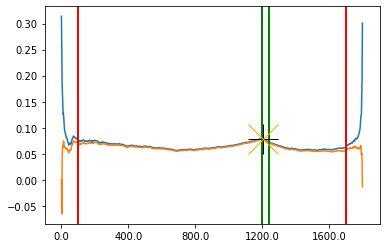

100%|████████████████████████████████████████████████████████████████████████████| 1212/1212 [00:00<00:00, 1601.05it/s]


Plot 2 - Embedding Perm 3 Error: -1098.0000 sec.
LR accuracy on training: 0.9942291838417148
LR accuracy on downsampled training: 0.9876339653751031


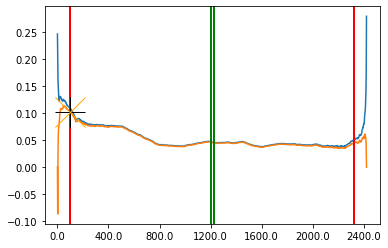

100%|████████████████████████████████████████████████████████████████████████████| 1218/1218 [00:00<00:00, 1615.39it/s]


Plot 3 - Embedding Perm 3 Error: 82.0000 sec.
LR accuracy on training: 0.9958982772764561
LR accuracy on downsampled training: 0.9598031173092699


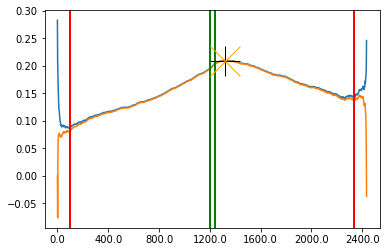

100%|████████████████████████████████████████████████████████████████████████████| 1131/1131 [00:00<00:00, 1913.73it/s]


Plot 4 - Embedding Perm 3 Error: -896.0000 sec.
LR accuracy on training: 0.9955830388692579
LR accuracy on downsampled training: 0.9885159010600707


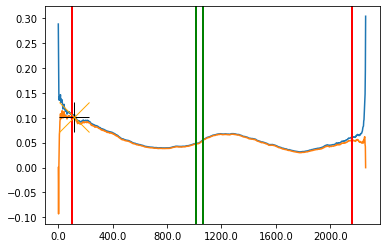

100%|████████████████████████████████████████████████████████████████████████████| 1243/1243 [00:00<00:00, 1506.67it/s]


Plot 5 - Embedding Perm 3 Error: -2.0000 sec.
LR accuracy on training: 0.9927652733118971
LR accuracy on downsampled training: 0.9935691318327974


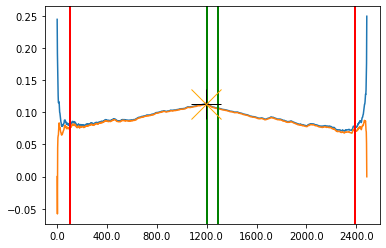

100%|██████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 4000.56it/s]


Plot 6 - Embedding Perm 3 Error: 32.0000 sec.
LR accuracy on training: 0.9950556242274413
LR accuracy on downsampled training: 0.9962917181705809


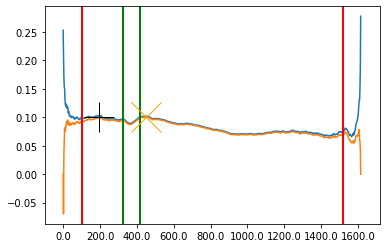

100%|██████████████████████████████████████████████████████████████████████████████| 830/830 [00:00<00:00, 3772.76it/s]


Plot 7 - Embedding Perm 3 Error: 0.0000 sec.
LR accuracy on training: 0.9915764139590855
LR accuracy on downsampled training: 0.9915764139590855


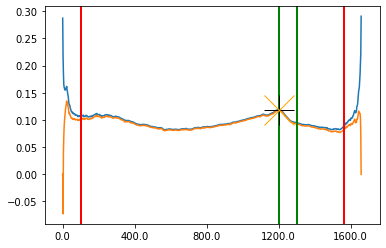

100%|██████████████████████████████████████████████████████████████████████████████| 478/478 [00:00<00:00, 9952.58it/s]

Plot 8 - Embedding Perm 3 Error: -2.0000 sec.
LR accuracy on training: 0.9895615866388309
LR accuracy on downsampled training: 0.9958246346555324


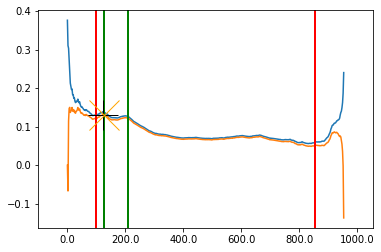

100%|██████████████████████████████████████████████████████████████████████████████| 912/912 [00:00<00:00, 3123.00it/s]


Plot 9 - Embedding Perm 3 Error: -376.0000 sec.
LR accuracy on training: 0.9901423877327492
LR accuracy on downsampled training: 0.9529025191675794


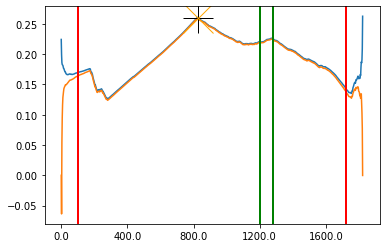

100%|██████████████████████████████████████████████████████████████████████████████| 714/714 [00:00<00:00, 4666.76it/s]


Plot 10 - Embedding Perm 3 Error: -156.0000 sec.
LR accuracy on training: 0.9944055944055944
LR accuracy on downsampled training: 0.9230769230769231


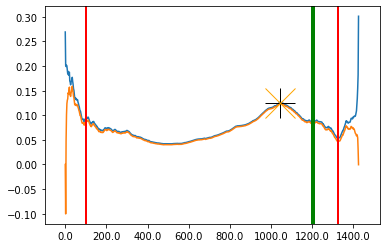

100%|██████████████████████████████████████████████████████████████████████████████| 805/805 [00:00<00:00, 3795.86it/s]


Plot 11 - Embedding Perm 3 Error: 0.0000 sec.
LR accuracy on training: 0.9714640198511166
LR accuracy on downsampled training: 0.9392059553349876


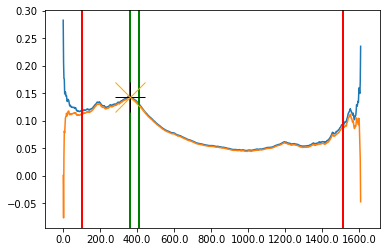

100%|██████████████████████████████████████████████████████████████████████████████| 996/996 [00:00<00:00, 2641.91it/s]


Plot 12 - Embedding Perm 3 Error: -64.0000 sec.
LR accuracy on training: 0.995987963891675
LR accuracy on downsampled training: 0.9849548645937813


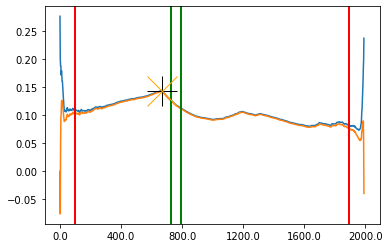

100%|██████████████████████████████████████████████████████████████████████████████| 849/849 [00:00<00:00, 3598.16it/s]


Plot 13 - Embedding Perm 3 Error: 1034.0000 sec.
LR accuracy on training: 0.9941176470588236
LR accuracy on downsampled training: 0.9152941176470588


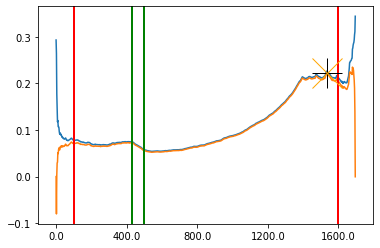

100%|████████████████████████████████████████████████████████████████████████████| 1224/1224 [00:00<00:00, 1561.12it/s]


Plot 14 - Embedding Perm 3 Error: 1094.0000 sec.
LR accuracy on training: 0.9983673469387755
LR accuracy on downsampled training: 0.9918367346938776


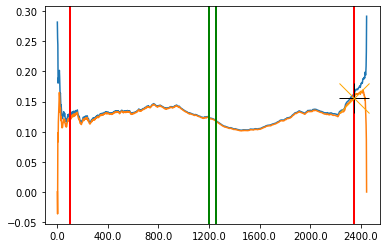

100%|████████████████████████████████████████████████████████████████████████████| 1222/1222 [00:00<00:00, 1580.80it/s]


Plot 15 - Embedding Perm 3 Error: -1008.0000 sec.
LR accuracy on training: 0.9828291087489779
LR accuracy on downsampled training: 0.9223221586263287


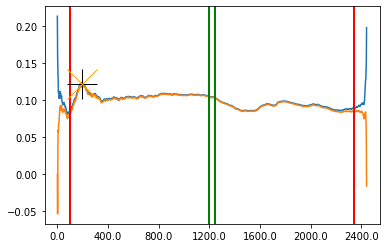

100%|████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 2078.70it/s]


Plot 16 - Embedding Perm 3 Error: -476.0000 sec.
LR accuracy on training: 0.9918404351767905
LR accuracy on downsampled training: 0.958295557570263


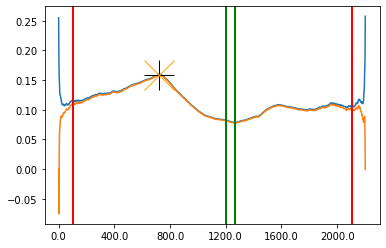

100%|████████████████████████████████████████████████████████████████████████████| 1225/1225 [00:00<00:00, 1418.47it/s]


Plot 17 - Embedding Perm 3 Error: -4.0000 sec.
LR accuracy on training: 0.9902120717781403
LR accuracy on downsampled training: 0.9469820554649266


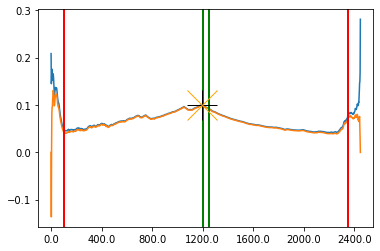

100%|████████████████████████████████████████████████████████████████████████████| 1223/1223 [00:00<00:00, 1482.43it/s]


Plot 18 - Embedding Perm 3 Error: -440.0000 sec.
LR accuracy on training: 0.9828431372549019
LR accuracy on downsampled training: 0.7050653594771242


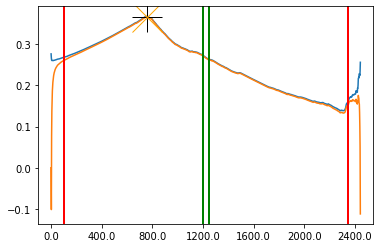

100%|████████████████████████████████████████████████████████████████████████████| 1254/1254 [00:00<00:00, 1278.29it/s]


Plot 19 - Embedding Perm 3 Error: 1088.0000 sec.
LR accuracy on training: 0.9936254980079682
LR accuracy on downsampled training: 0.9864541832669322


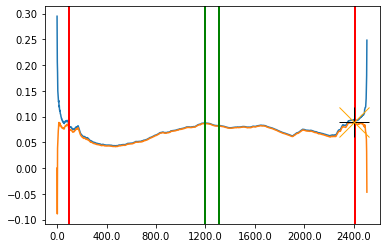

100%|██████████████████████████████████████████████████████████████████████████████| 864/864 [00:00<00:00, 3075.06it/s]


Plot 20 - Embedding Perm 3 Error: 0.0000 sec.
LR accuracy on training: 0.9988439306358381
LR accuracy on downsampled training: 0.9988439306358381


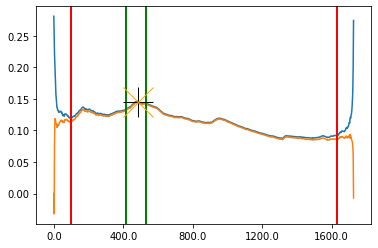

100%|████████████████████████████████████████████████████████████████████████████| 1196/1196 [00:00<00:00, 1480.25it/s]


Plot 21 - Embedding Perm 3 Error: 44.0000 sec.
LR accuracy on training: 0.9966583124477861
LR accuracy on downsampled training: 0.9983291562238931


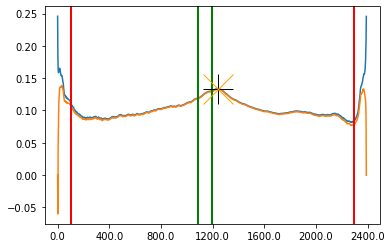

100%|████████████████████████████████████████████████████████████████████████████| 1240/1240 [00:00<00:00, 1365.88it/s]


Plot 22 - Embedding Perm 3 Error: 978.0000 sec.
LR accuracy on training: 0.9951651893634166
LR accuracy on downsampled training: 0.9975825946817083


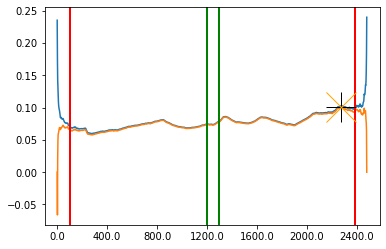

100%|████████████████████████████████████████████████████████████████████████████| 1173/1173 [00:00<00:00, 1570.66it/s]


Plot 23 - Embedding Perm 3 Error: -602.0000 sec.
LR accuracy on training: 0.989778534923339
LR accuracy on downsampled training: 0.9744463373083475


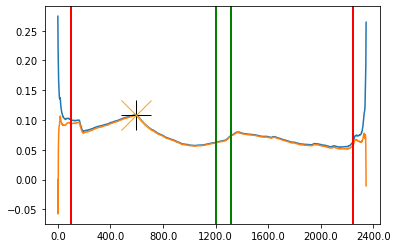

100%|████████████████████████████████████████████████████████████████████████████| 1224/1224 [00:00<00:00, 1573.57it/s]


Plot 24 - Embedding Perm 3 Error: 0.0000 sec.
LR accuracy on training: 0.9934693877551021
LR accuracy on downsampled training: 0.9975510204081632


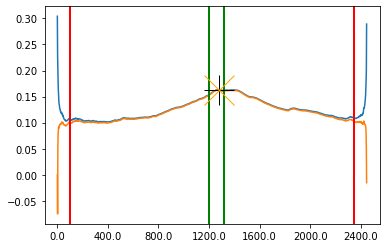

100%|████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 1580.84it/s]


Plot 25 - Embedding Perm 3 Error: 130.0000 sec.
LR accuracy on training: 0.9925434962717481
LR accuracy on downsampled training: 0.9221209610604806


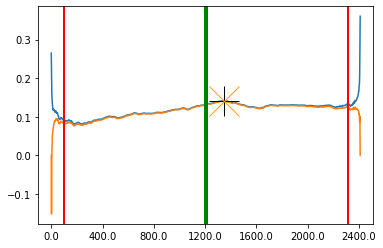

100%|████████████████████████████████████████████████████████████████████████████| 1204/1204 [00:00<00:00, 1557.90it/s]


Plot 26 - Embedding Perm 3 Error: -838.0000 sec.
LR accuracy on training: 0.9941908713692946
LR accuracy on downsampled training: 0.8879668049792531


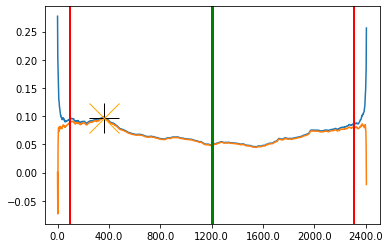

100%|██████████████████████████████████████████████████████████████████████████████| 858/858 [00:00<00:00, 3000.63it/s]


Plot 27 - Embedding Perm 3 Error: -16.0000 sec.
LR accuracy on training: 0.9906868451688009
LR accuracy on downsampled training: 0.8463329452852154


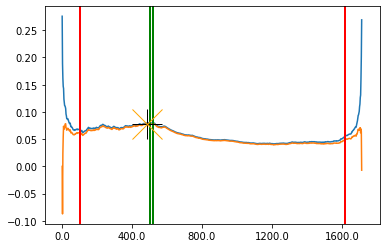

100%|██████████████████████████████████████████████████████████████████████████████| 663/663 [00:00<00:00, 4805.39it/s]


Plot 28 - Embedding Perm 3 Error: 8.0000 sec.
LR accuracy on training: 0.9894578313253012
LR accuracy on downsampled training: 0.7274096385542169


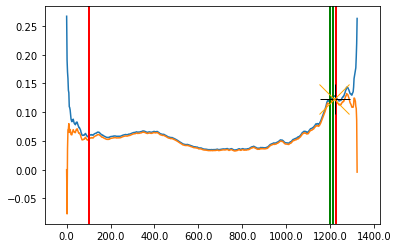

100%|████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 1677.47it/s]


Plot 29 - Embedding Perm 3 Error: -1096.0000 sec.
LR accuracy on training: 0.9925434962717481
LR accuracy on downsampled training: 0.7224523612261806


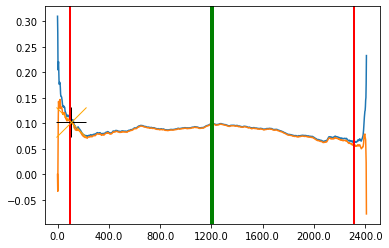

100%|████████████████████████████████████████████████████████████████████████████| 1241/1241 [00:00<00:00, 1524.95it/s]


Plot 30 - Embedding Perm 3 Error: 982.0000 sec.
LR accuracy on training: 0.9903381642512077
LR accuracy on downsampled training: 0.9895330112721417


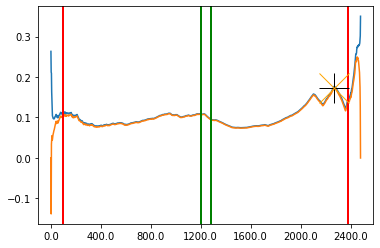

100%|██████████████████████████████████████████████████████████████████████████████| 819/819 [00:00<00:00, 3427.03it/s]


Plot 31 - Embedding Perm 3 Error: 52.0000 sec.
LR accuracy on training: 0.9865853658536585
LR accuracy on downsampled training: 0.9951219512195122


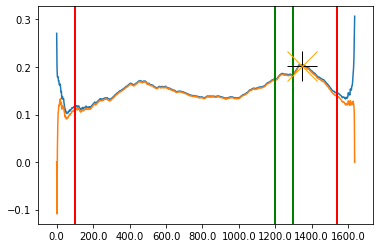

100%|██████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 2857.88it/s]


Plot 32 - Embedding Perm 3 Error: 38.0000 sec.
LR accuracy on training: 0.9875130072840791
LR accuracy on downsampled training: 0.9895941727367326


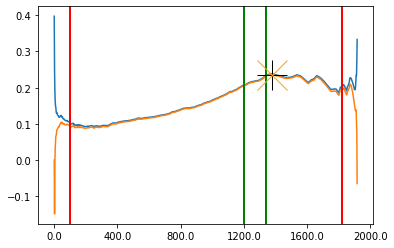

100%|████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:00<00:00, 2174.27it/s]


Plot 33 - Embedding Perm 3 Error: 390.0000 sec.
LR accuracy on training: 0.9708646616541353
LR accuracy on downsampled training: 0.9577067669172933


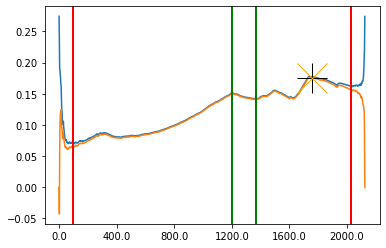

100%|██████████████████████████████████████████████████████████████████████████████| 970/970 [00:00<00:00, 2702.25it/s]


Plot 34 - Embedding Perm 3 Error: 208.0000 sec.
LR accuracy on training: 0.976313079299691
LR accuracy on downsampled training: 0.9639546858908342


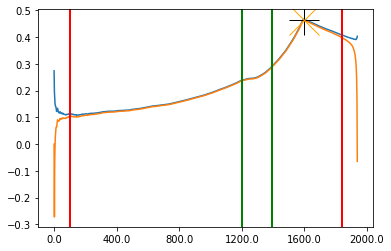

100%|██████████████████████████████████████████████████████████████████████████████| 904/904 [00:00<00:00, 2955.19it/s]


Plot 35 - Embedding Perm 3 Error: 0.0000 sec.
LR accuracy on training: 0.9834254143646409
LR accuracy on downsampled training: 0.9756906077348066


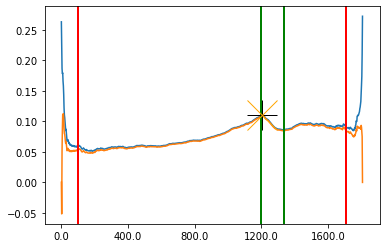

100%|████████████████████████████████████████████████████████████████████████████| 1190/1190 [00:00<00:00, 1610.63it/s]


Plot 36 - Embedding Perm 3 Error: 0.0000 sec.
LR accuracy on training: 0.984047019311503
LR accuracy on downsampled training: 0.9513014273719563


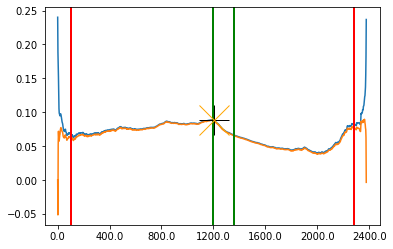

100%|████████████████████████████████████████████████████████████████████████████| 1330/1330 [00:01<00:00, 1191.97it/s]


Plot 37 - Embedding Perm 3 Error: 0.0000 sec.
LR accuracy on training: 0.9496619083395943
LR accuracy on downsampled training: 0.8655146506386175


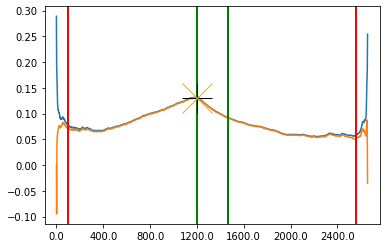

100%|████████████████████████████████████████████████████████████████████████████| 1230/1230 [00:00<00:00, 1468.13it/s]


Plot 38 - Embedding Perm 3 Error: 0.0000 sec.
LR accuracy on training: 0.9926888708367181
LR accuracy on downsampled training: 0.9943135662063363


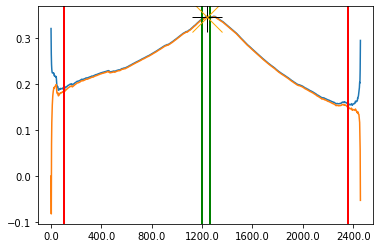

100%|██████████████████████████████████████████████████████████████████████████████| 799/799 [00:00<00:00, 3769.61it/s]


Plot 39 - Embedding Perm 3 Error: 96.0000 sec.
LR accuracy on training: 0.99375
LR accuracy on downsampled training: 0.9975


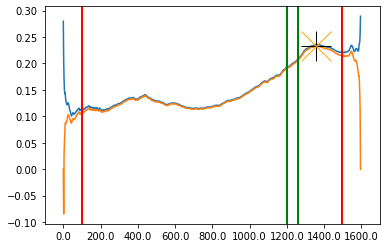

100%|████████████████████████████████████████████████████████████████████████████| 1042/1042 [00:00<00:00, 2352.65it/s]


Plot 40 - Embedding Perm 3 Error: 476.0000 sec.
LR accuracy on training: 0.9952061361457335
LR accuracy on downsampled training: 0.9942473633748802


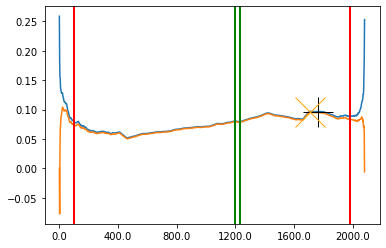

100%|██████████████████████████████████████████████████████████████████████████████| 760/760 [00:00<00:00, 4551.07it/s]


Plot 41 - Embedding Perm 3 Error: 6.0000 sec.
LR accuracy on training: 0.9947437582128777
LR accuracy on downsampled training: 0.9973718791064389


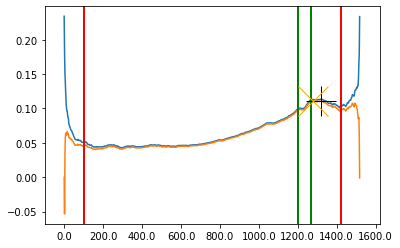

100%|████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:00<00:00, 1467.45it/s]


Plot 42 - Embedding Perm 3 Error: 944.0000 sec.
LR accuracy on training: 0.9991883116883117
LR accuracy on downsampled training: 1.0


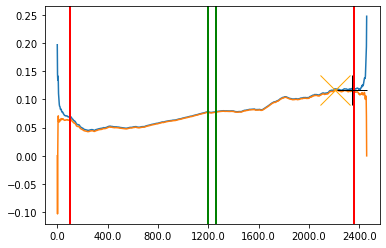

100%|████████████████████████████████████████████████████████████████████████████| 1227/1227 [00:00<00:00, 1394.12it/s]


Plot 43 - Embedding Perm 3 Error: 0.0000 sec.
LR accuracy on training: 0.996742671009772
LR accuracy on downsampled training: 0.999185667752443


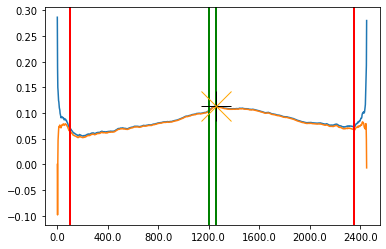

100%|████████████████████████████████████████████████████████████████████████████| 1236/1236 [00:00<00:00, 1501.85it/s]


Plot 44 - Embedding Perm 3 Error: -946.0000 sec.
LR accuracy on training: 0.994341147938561
LR accuracy on downsampled training: 0.9959579628132579


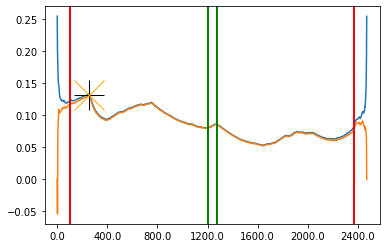

100%|████████████████████████████████████████████████████████████████████████████| 1243/1243 [00:00<00:00, 1347.45it/s]


Plot 45 - Embedding Perm 3 Error: 658.0000 sec.
LR accuracy on training: 0.9935691318327974
LR accuracy on downsampled training: 0.9943729903536977


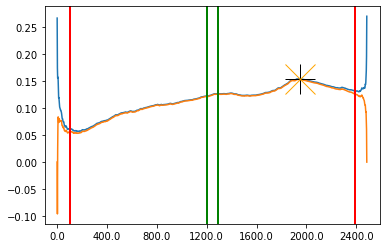

100%|████████████████████████████████████████████████████████████████████████████| 1225/1225 [00:00<00:00, 1503.21it/s]


Plot 46 - Embedding Perm 3 Error: -842.0000 sec.
LR accuracy on training: 0.9934747145187602
LR accuracy on downsampled training: 0.9836867862969005


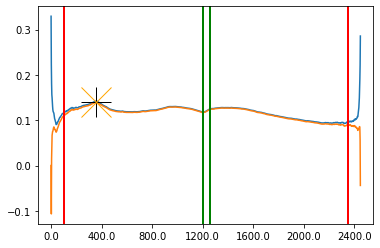

Total accuracy: 0.2127659574468085
LR accuracy on validation: 0.9889012208657048
LR accuracy on downsampled validation: [0.9047619047619048]


C:\Users\djnak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\djnak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

In [8]:
main()

100%|██████████████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 1276.60it/s]


Plot 1 - Embedding Perm 4 Error: 0.0000 sec.
LR accuracy on training: 0.9822419533851277
LR accuracy on downsampled training: 0.6190476190476191


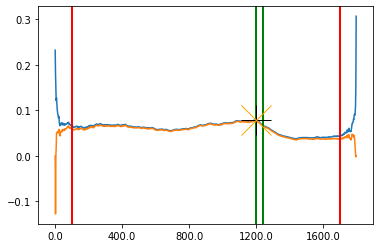

100%|█████████████████████████████████████████████████████████████████████████████| 1212/1212 [00:01<00:00, 722.29it/s]


Plot 2 - Embedding Perm 4 Error: -1100.0000 sec.
LR accuracy on training: 0.9901071723000825
LR accuracy on downsampled training: 0.5714285714285714


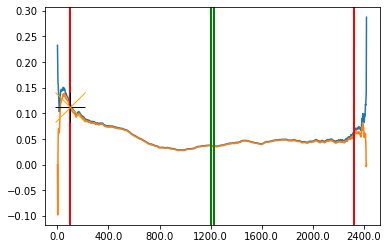

100%|█████████████████████████████████████████████████████████████████████████████| 1218/1218 [00:01<00:00, 630.42it/s]


Plot 3 - Embedding Perm 4 Error: 32.0000 sec.
LR accuracy on training: 0.985233798195242
LR accuracy on downsampled training: 0.5714285714285714


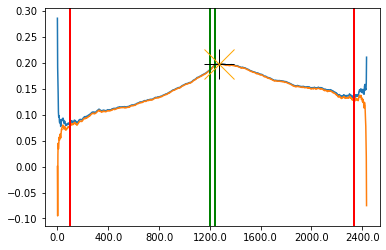

100%|█████████████████████████████████████████████████████████████████████████████| 1131/1131 [00:01<00:00, 684.57it/s]


Plot 4 - Embedding Perm 4 Error: -896.0000 sec.
LR accuracy on training: 0.9832155477031802
LR accuracy on downsampled training: 0.5961538461538461


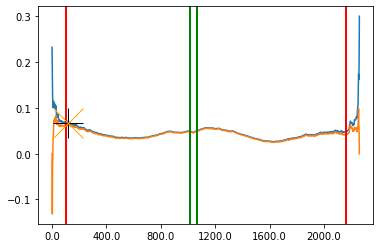

100%|█████████████████████████████████████████████████████████████████████████████| 1243/1243 [00:02<00:00, 584.38it/s]


Plot 5 - Embedding Perm 4 Error: 1094.0000 sec.
LR accuracy on training: 0.9815112540192926
LR accuracy on downsampled training: 0.7391304347826086


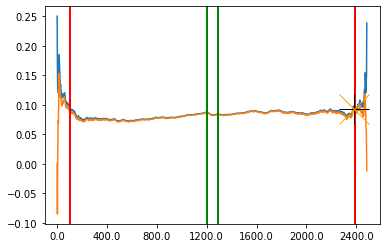

100%|██████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 1351.05it/s]


Plot 6 - Embedding Perm 4 Error: -226.0000 sec.
LR accuracy on training: 0.9752781211372065
LR accuracy on downsampled training: 0.776595744680851


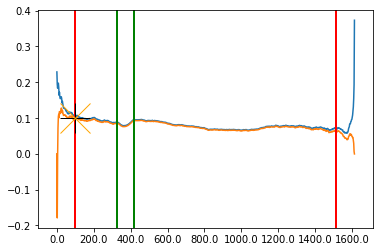

100%|██████████████████████████████████████████████████████████████████████████████| 830/830 [00:00<00:00, 2294.15it/s]


Plot 7 - Embedding Perm 4 Error: 0.0000 sec.
LR accuracy on training: 0.9711191335740073
LR accuracy on downsampled training: 0.7549019607843137


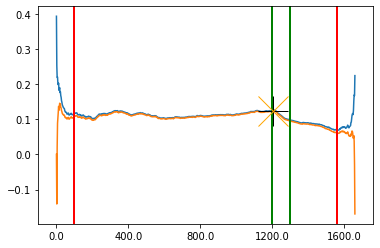

100%|██████████████████████████████████████████████████████████████████████████████| 478/478 [00:00<00:00, 9193.02it/s]

Plot 8 - Embedding Perm 4 Error: 0.0000 sec.
LR accuracy on training: 0.9102296450939458
LR accuracy on downsampled training: 0.5


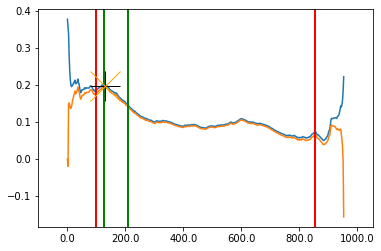

100%|██████████████████████████████████████████████████████████████████████████████| 912/912 [00:00<00:00, 1312.23it/s]


Plot 9 - Embedding Perm 4 Error: 0.0000 sec.
LR accuracy on training: 0.9550930996714129
LR accuracy on downsampled training: 0.5


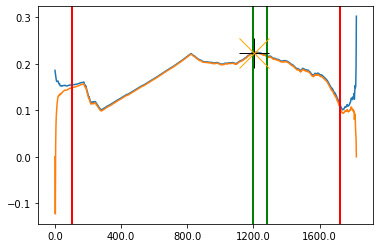

100%|██████████████████████████████████████████████████████████████████████████████| 714/714 [00:00<00:00, 4011.26it/s]


Plot 10 - Embedding Perm 4 Error: -154.0000 sec.
LR accuracy on training: 0.993006993006993
LR accuracy on downsampled training: 0.5


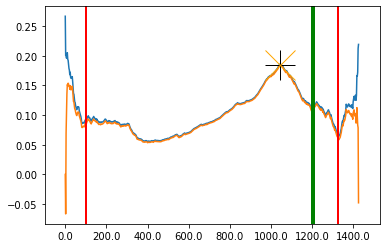

100%|██████████████████████████████████████████████████████████████████████████████| 805/805 [00:00<00:00, 1800.77it/s]


Plot 11 - Embedding Perm 4 Error: -176.0000 sec.
LR accuracy on training: 0.966501240694789
LR accuracy on downsampled training: 0.5


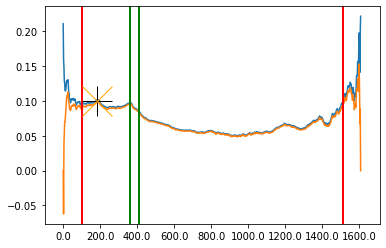

100%|██████████████████████████████████████████████████████████████████████████████| 996/996 [00:00<00:00, 1210.21it/s]


Plot 12 - Embedding Perm 4 Error: -64.0000 sec.
LR accuracy on training: 0.9729187562688064
LR accuracy on downsampled training: 0.5909090909090909


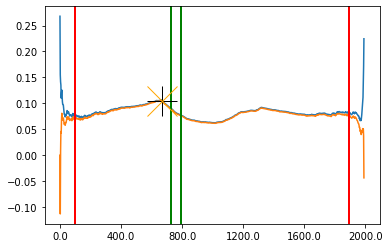

100%|██████████████████████████████████████████████████████████████████████████████| 849/849 [00:00<00:00, 1890.87it/s]


Plot 13 - Embedding Perm 4 Error: 1032.0000 sec.
LR accuracy on training: 0.9588235294117647
LR accuracy on downsampled training: 0.5138888888888888


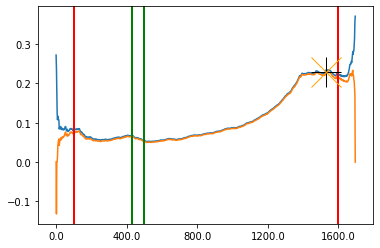

100%|█████████████████████████████████████████████████████████████████████████████| 1224/1224 [00:01<00:00, 706.26it/s]


Plot 14 - Embedding Perm 4 Error: 1082.0000 sec.
LR accuracy on training: 0.9771428571428571
LR accuracy on downsampled training: 0.5555555555555556


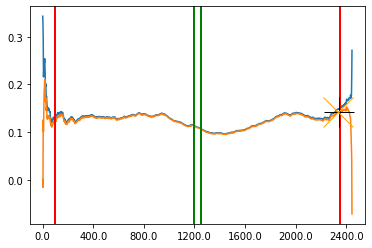

100%|█████████████████████████████████████████████████████████████████████████████| 1222/1222 [00:01<00:00, 773.90it/s]


Plot 15 - Embedding Perm 4 Error: -38.0000 sec.
LR accuracy on training: 0.9803761242845462
LR accuracy on downsampled training: 0.5208333333333334


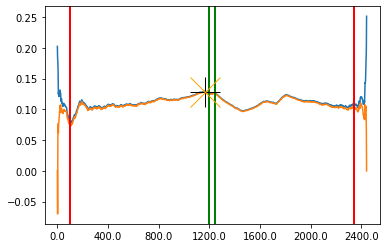

100%|████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:01<00:00, 1039.57it/s]


Plot 16 - Embedding Perm 4 Error: -478.0000 sec.
LR accuracy on training: 0.9682683590208522
LR accuracy on downsampled training: 0.5151515151515151


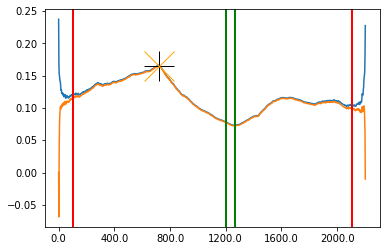

100%|█████████████████████████████████████████████████████████████████████████████| 1225/1225 [00:01<00:00, 737.28it/s]


Plot 17 - Embedding Perm 4 Error: -4.0000 sec.
LR accuracy on training: 0.9771615008156607
LR accuracy on downsampled training: 0.5


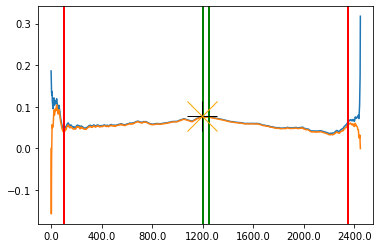

100%|█████████████████████████████████████████████████████████████████████████████| 1223/1223 [00:01<00:00, 794.13it/s]


Plot 18 - Embedding Perm 4 Error: -452.0000 sec.
LR accuracy on training: 0.9795751633986928
LR accuracy on downsampled training: 0.5


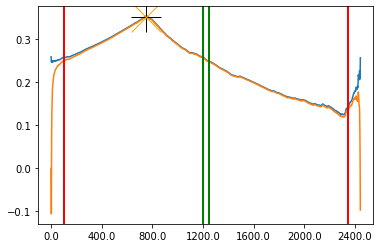

100%|█████████████████████████████████████████████████████████████████████████████| 1254/1254 [00:01<00:00, 703.34it/s]


Plot 19 - Embedding Perm 4 Error: 1094.0000 sec.
LR accuracy on training: 0.9553784860557769
LR accuracy on downsampled training: 0.5


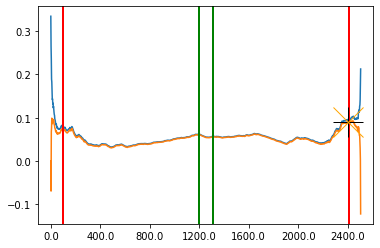

100%|██████████████████████████████████████████████████████████████████████████████| 864/864 [00:00<00:00, 1885.48it/s]


Plot 20 - Embedding Perm 4 Error: 1084.0000 sec.
LR accuracy on training: 0.9849710982658959
LR accuracy on downsampled training: 0.8793103448275862


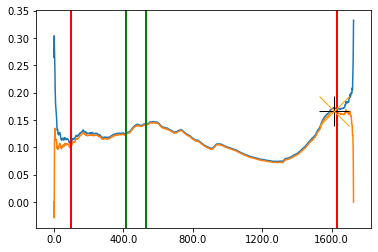

100%|█████████████████████████████████████████████████████████████████████████████| 1196/1196 [00:01<00:00, 796.22it/s]


Plot 21 - Embedding Perm 4 Error: 44.0000 sec.
LR accuracy on training: 0.9849624060150376
LR accuracy on downsampled training: 0.8482142857142857


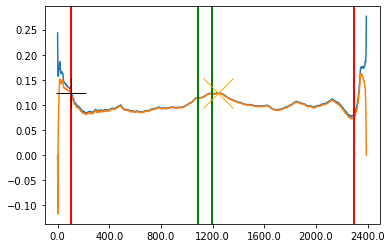

100%|█████████████████████████████████████████████████████████████████████████████| 1240/1240 [00:01<00:00, 753.05it/s]


Plot 22 - Embedding Perm 4 Error: 986.0000 sec.
LR accuracy on training: 0.9750201450443191
LR accuracy on downsampled training: 0.6632653061224489


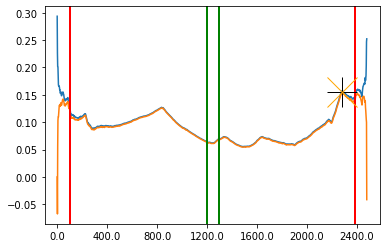

100%|█████████████████████████████████████████████████████████████████████████████| 1173/1173 [00:01<00:00, 887.29it/s]


Plot 23 - Embedding Perm 4 Error: -604.0000 sec.
LR accuracy on training: 0.9676320272572402
LR accuracy on downsampled training: 0.6885245901639344


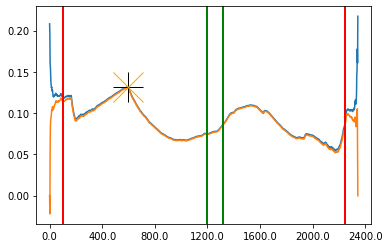

100%|█████████████████████████████████████████████████████████████████████████████| 1224/1224 [00:01<00:00, 772.73it/s]


Plot 24 - Embedding Perm 4 Error: 140.0000 sec.
LR accuracy on training: 0.9804081632653061
LR accuracy on downsampled training: 0.7966101694915254


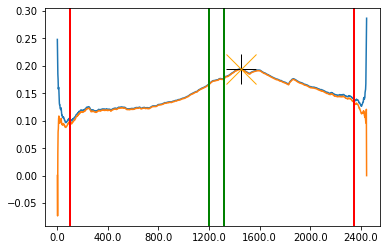

100%|█████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:01<00:00, 808.57it/s]


Plot 25 - Embedding Perm 4 Error: 1058.0000 sec.
LR accuracy on training: 0.9925434962717481
LR accuracy on downsampled training: 0.5


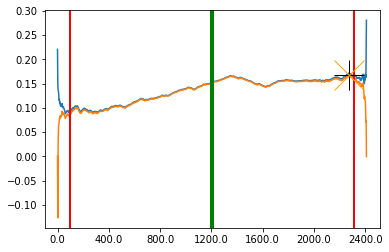

100%|█████████████████████████████████████████████████████████████████████████████| 1204/1204 [00:01<00:00, 770.77it/s]


Plot 26 - Embedding Perm 4 Error: -836.0000 sec.
LR accuracy on training: 0.9941908713692946
LR accuracy on downsampled training: 0.5


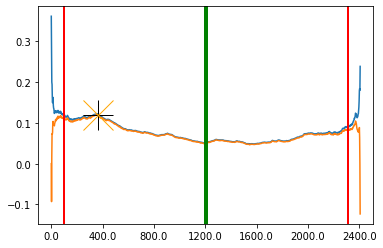

100%|██████████████████████████████████████████████████████████████████████████████| 858/858 [00:00<00:00, 1881.57it/s]


Plot 27 - Embedding Perm 4 Error: 66.0000 sec.
LR accuracy on training: 0.9906868451688009
LR accuracy on downsampled training: 0.5


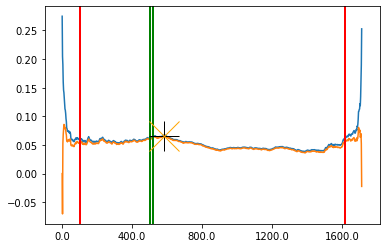

100%|██████████████████████████████████████████████████████████████████████████████| 663/663 [00:00<00:00, 3854.64it/s]


Plot 28 - Embedding Perm 4 Error: 8.0000 sec.
LR accuracy on training: 0.9894578313253012
LR accuracy on downsampled training: 0.5


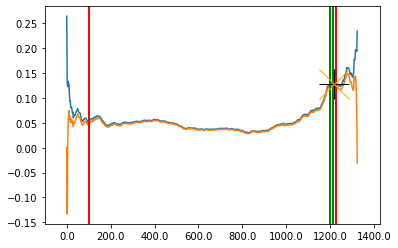

100%|█████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:01<00:00, 722.59it/s]


Plot 29 - Embedding Perm 4 Error: -1100.0000 sec.
LR accuracy on training: 0.9925434962717481
LR accuracy on downsampled training: 0.5


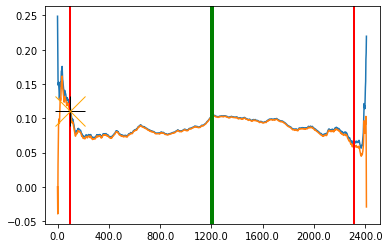

100%|█████████████████████████████████████████████████████████████████████████████| 1241/1241 [00:01<00:00, 709.53it/s]


Plot 30 - Embedding Perm 4 Error: 986.0000 sec.
LR accuracy on training: 0.9830917874396136
LR accuracy on downsampled training: 0.75


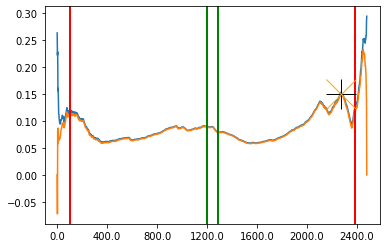

100%|██████████████████████████████████████████████████████████████████████████████| 819/819 [00:00<00:00, 2401.77it/s]


Plot 31 - Embedding Perm 4 Error: 34.0000 sec.
LR accuracy on training: 0.9646341463414634
LR accuracy on downsampled training: 0.6836734693877551


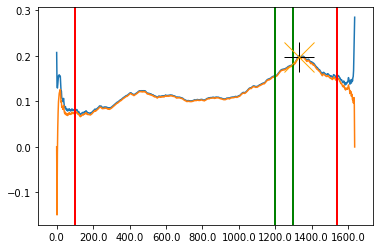

100%|██████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 1263.16it/s]


Plot 32 - Embedding Perm 4 Error: 50.0000 sec.
LR accuracy on training: 0.9542143600416233
LR accuracy on downsampled training: 0.6805555555555556


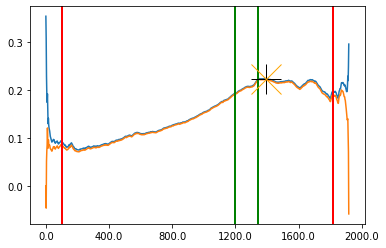

100%|█████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:01<00:00, 997.19it/s]


Plot 33 - Embedding Perm 4 Error: 592.0000 sec.
LR accuracy on training: 0.9389097744360902
LR accuracy on downsampled training: 0.622093023255814


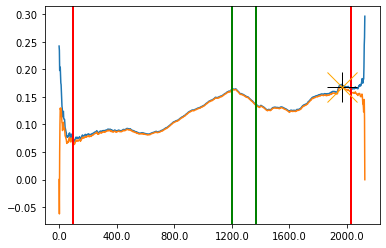

100%|██████████████████████████████████████████████████████████████████████████████| 970/970 [00:00<00:00, 1305.39it/s]


Plot 34 - Embedding Perm 4 Error: 208.0000 sec.
LR accuracy on training: 0.917610710607621
LR accuracy on downsampled training: 0.59375


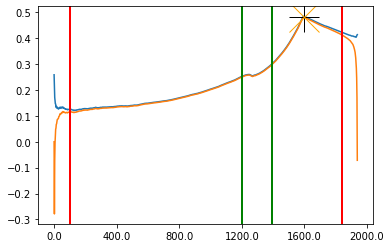

100%|██████████████████████████████████████████████████████████████████████████████| 904/904 [00:00<00:00, 1588.75it/s]


Plot 35 - Embedding Perm 4 Error: 0.0000 sec.
LR accuracy on training: 0.9425414364640884
LR accuracy on downsampled training: 0.6102941176470589


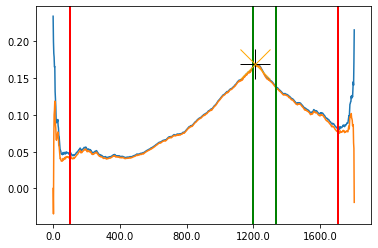

100%|█████████████████████████████████████████████████████████████████████████████| 1190/1190 [00:01<00:00, 812.29it/s]


Plot 36 - Embedding Perm 4 Error: -334.0000 sec.
LR accuracy on training: 0.9403862300587741
LR accuracy on downsampled training: 0.5679012345679012


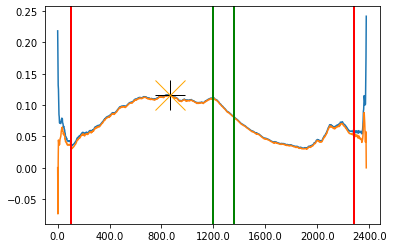

100%|█████████████████████████████████████████████████████████████████████████████| 1330/1330 [00:02<00:00, 644.87it/s]


Plot 37 - Embedding Perm 4 Error: 0.0000 sec.
LR accuracy on training: 0.9331329827197595
LR accuracy on downsampled training: 0.6766917293233082


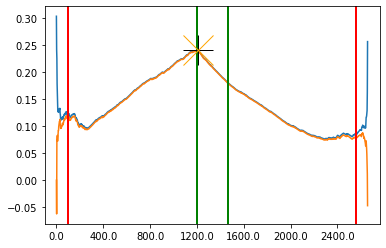

100%|█████████████████████████████████████████████████████████████████████████████| 1230/1230 [00:01<00:00, 745.21it/s]


Plot 38 - Embedding Perm 4 Error: 40.0000 sec.
LR accuracy on training: 0.9902518277822908
LR accuracy on downsampled training: 0.803030303030303


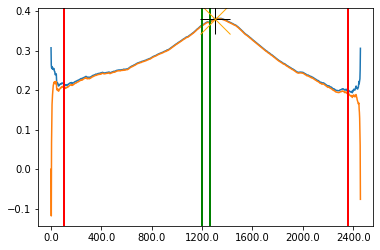

100%|██████████████████████████████████████████████████████████████████████████████| 799/799 [00:00<00:00, 2663.34it/s]


Plot 39 - Embedding Perm 4 Error: 78.0000 sec.
LR accuracy on training: 0.98375
LR accuracy on downsampled training: 0.796875


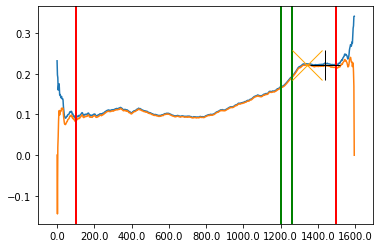

100%|████████████████████████████████████████████████████████████████████████████| 1042/1042 [00:00<00:00, 1148.16it/s]


Plot 40 - Embedding Perm 4 Error: 172.0000 sec.
LR accuracy on training: 0.9913710450623202
LR accuracy on downsampled training: 0.75


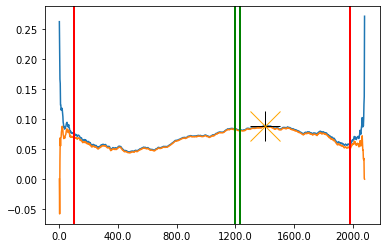

100%|██████████████████████████████████████████████████████████████████████████████| 760/760 [00:00<00:00, 3115.09it/s]


Plot 41 - Embedding Perm 4 Error: 0.0000 sec.
LR accuracy on training: 0.985545335085414
LR accuracy on downsampled training: 0.8333333333333334


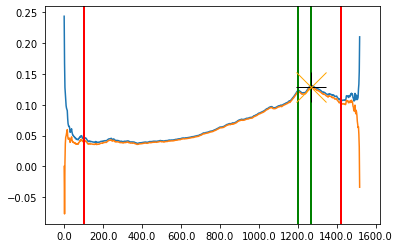

100%|█████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:01<00:00, 724.12it/s]


Plot 42 - Embedding Perm 4 Error: 898.0000 sec.
LR accuracy on training: 0.989448051948052
LR accuracy on downsampled training: 0.7727272727272727


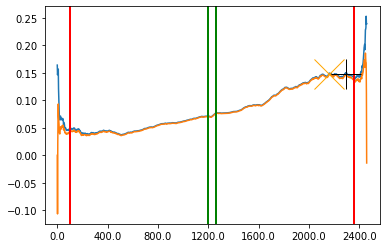

100%|█████████████████████████████████████████████████████████████████████████████| 1227/1227 [00:01<00:00, 728.40it/s]


Plot 43 - Embedding Perm 4 Error: 124.0000 sec.
LR accuracy on training: 0.989413680781759
LR accuracy on downsampled training: 0.7666666666666667


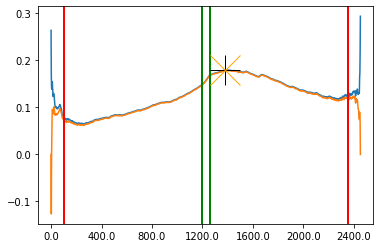

100%|█████████████████████████████████████████████████████████████████████████████| 1236/1236 [00:01<00:00, 790.28it/s]


Plot 44 - Embedding Perm 4 Error: -946.0000 sec.
LR accuracy on training: 0.9870654810024252
LR accuracy on downsampled training: 0.7692307692307693


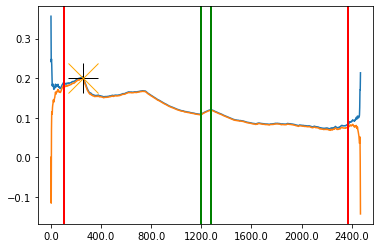

100%|█████████████████████████████████████████████████████████████████████████████| 1243/1243 [00:01<00:00, 767.04it/s]


Plot 45 - Embedding Perm 4 Error: 842.0000 sec.
LR accuracy on training: 0.9790996784565916
LR accuracy on downsampled training: 0.7111111111111111


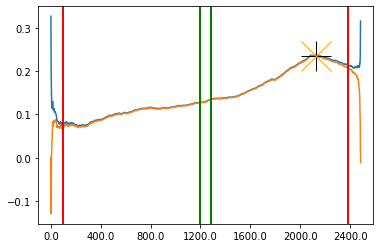

100%|█████████████████████████████████████████████████████████████████████████████| 1225/1225 [00:01<00:00, 736.18it/s]


Plot 46 - Embedding Perm 4 Error: 206.0000 sec.
LR accuracy on training: 0.9836867862969005
LR accuracy on downsampled training: 0.6428571428571429


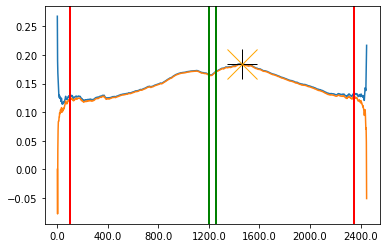

Total accuracy: 0.14893617021276595
LR accuracy on validation: 0.9822419533851277
LR accuracy on downsampled validation: [0.6190476190476191, 0.6190476190476191]


C:\Users\djnak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [11]:
main(emb=4)

100%|██████████████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 1829.27it/s]


Plot 1 - Embedding Perm 5 Error: 0.0000 sec.
LR accuracy on training: 0.9822419533851277
LR accuracy on downsampled training: 0.6190476190476191


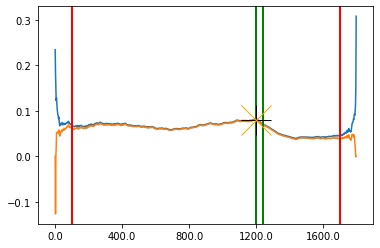

100%|█████████████████████████████████████████████████████████████████████████████| 1212/1212 [00:01<00:00, 717.79it/s]


Plot 2 - Embedding Perm 5 Error: -1100.0000 sec.
LR accuracy on training: 0.9901071723000825
LR accuracy on downsampled training: 0.5714285714285714


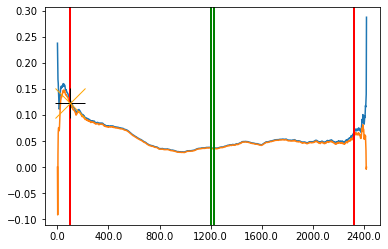

100%|█████████████████████████████████████████████████████████████████████████████| 1218/1218 [00:01<00:00, 771.12it/s]


Plot 3 - Embedding Perm 5 Error: 32.0000 sec.
LR accuracy on training: 0.985233798195242
LR accuracy on downsampled training: 0.5476190476190477


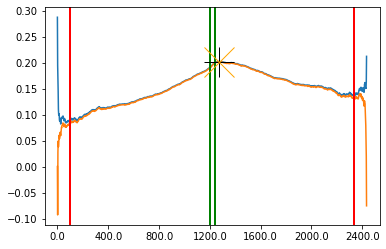

100%|█████████████████████████████████████████████████████████████████████████████| 1131/1131 [00:01<00:00, 896.91it/s]


Plot 4 - Embedding Perm 5 Error: -896.0000 sec.
LR accuracy on training: 0.9840989399293286
LR accuracy on downsampled training: 0.6346153846153846


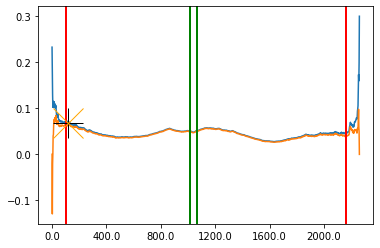

100%|█████████████████████████████████████████████████████████████████████████████| 1243/1243 [00:01<00:00, 736.81it/s]


Plot 5 - Embedding Perm 5 Error: 1086.0000 sec.
LR accuracy on training: 0.9815112540192926
LR accuracy on downsampled training: 0.75


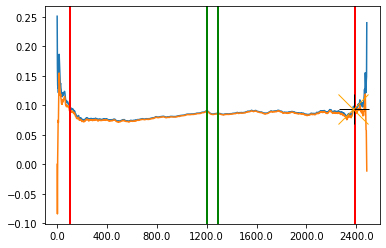

100%|██████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 2315.17it/s]


Plot 6 - Embedding Perm 5 Error: -226.0000 sec.
LR accuracy on training: 0.9765142150803461
LR accuracy on downsampled training: 0.7872340425531915


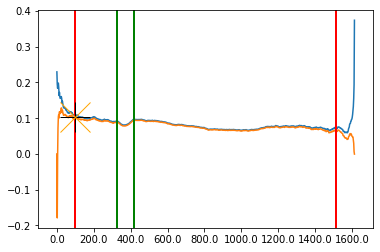

100%|██████████████████████████████████████████████████████████████████████████████| 830/830 [00:00<00:00, 2391.93it/s]


Plot 7 - Embedding Perm 5 Error: 0.0000 sec.
LR accuracy on training: 0.9699157641395909
LR accuracy on downsampled training: 0.7450980392156863


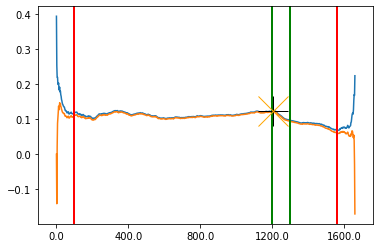

100%|██████████████████████████████████████████████████████████████████████████████| 478/478 [00:00<00:00, 8851.71it/s]

Plot 8 - Embedding Perm 5 Error: 0.0000 sec.
LR accuracy on training: 0.9102296450939458
LR accuracy on downsampled training: 0.5


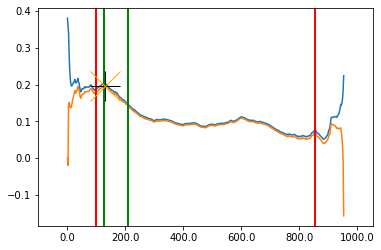

100%|██████████████████████████████████████████████████████████████████████████████| 912/912 [00:00<00:00, 1767.45it/s]


Plot 9 - Embedding Perm 5 Error: 0.0000 sec.
LR accuracy on training: 0.9550930996714129
LR accuracy on downsampled training: 0.5


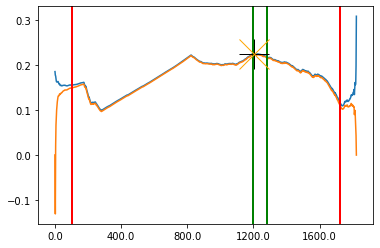

100%|██████████████████████████████████████████████████████████████████████████████| 714/714 [00:00<00:00, 3606.09it/s]


Plot 10 - Embedding Perm 5 Error: -154.0000 sec.
LR accuracy on training: 0.993006993006993
LR accuracy on downsampled training: 0.5


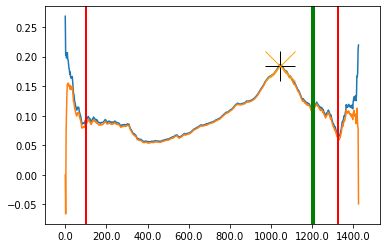

100%|██████████████████████████████████████████████████████████████████████████████| 805/805 [00:00<00:00, 2286.93it/s]


Plot 11 - Embedding Perm 5 Error: -176.0000 sec.
LR accuracy on training: 0.966501240694789
LR accuracy on downsampled training: 0.5


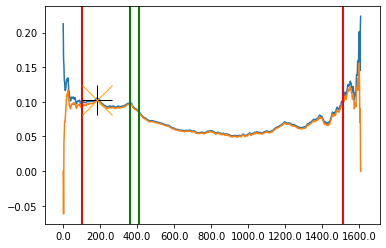

100%|██████████████████████████████████████████████████████████████████████████████| 996/996 [00:00<00:00, 1154.74it/s]


Plot 12 - Embedding Perm 5 Error: -64.0000 sec.
LR accuracy on training: 0.9729187562688064
LR accuracy on downsampled training: 0.6060606060606061


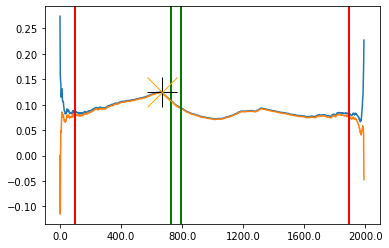

100%|██████████████████████████████████████████████████████████████████████████████| 849/849 [00:00<00:00, 2176.80it/s]


Plot 13 - Embedding Perm 5 Error: 1032.0000 sec.
LR accuracy on training: 0.9588235294117647
LR accuracy on downsampled training: 0.5138888888888888


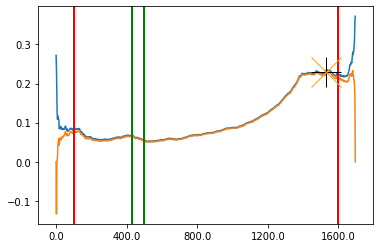

100%|█████████████████████████████████████████████████████████████████████████████| 1224/1224 [00:01<00:00, 884.22it/s]


Plot 14 - Embedding Perm 5 Error: 1088.0000 sec.
LR accuracy on training: 0.9771428571428571
LR accuracy on downsampled training: 0.5555555555555556


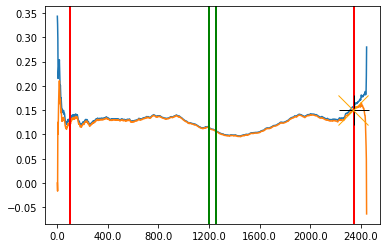

100%|█████████████████████████████████████████████████████████████████████████████| 1222/1222 [00:01<00:00, 772.72it/s]


Plot 15 - Embedding Perm 5 Error: -38.0000 sec.
LR accuracy on training: 0.9803761242845462
LR accuracy on downsampled training: 0.5208333333333334


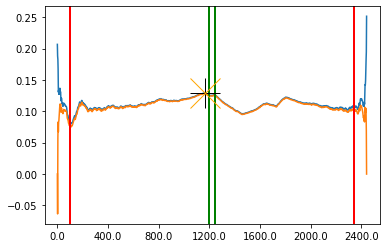

100%|████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:01<00:00, 1068.20it/s]


Plot 16 - Embedding Perm 5 Error: -478.0000 sec.
LR accuracy on training: 0.9682683590208522
LR accuracy on downsampled training: 0.5151515151515151


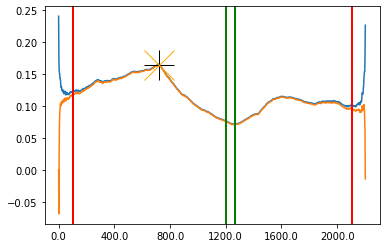

100%|████████████████████████████████████████████████████████████████████████████| 1225/1225 [00:00<00:00, 1239.63it/s]


Plot 17 - Embedding Perm 5 Error: 0.0000 sec.
LR accuracy on training: 0.9771615008156607
LR accuracy on downsampled training: 0.5


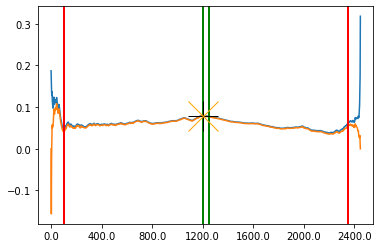

100%|████████████████████████████████████████████████████████████████████████████| 1223/1223 [00:00<00:00, 1343.86it/s]


Plot 18 - Embedding Perm 5 Error: -452.0000 sec.
LR accuracy on training: 0.9795751633986928
LR accuracy on downsampled training: 0.5


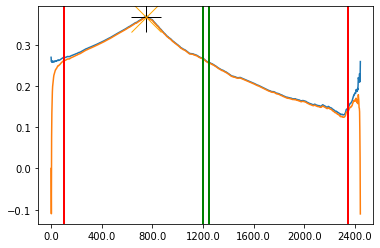

100%|████████████████████████████████████████████████████████████████████████████| 1254/1254 [00:01<00:00, 1024.30it/s]


Plot 19 - Embedding Perm 5 Error: 1094.0000 sec.
LR accuracy on training: 0.9553784860557769
LR accuracy on downsampled training: 0.5


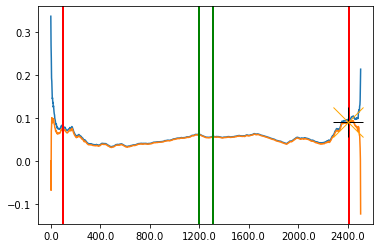

100%|██████████████████████████████████████████████████████████████████████████████| 864/864 [00:00<00:00, 3211.93it/s]


Plot 20 - Embedding Perm 5 Error: 1084.0000 sec.
LR accuracy on training: 0.9849710982658959
LR accuracy on downsampled training: 0.8620689655172413


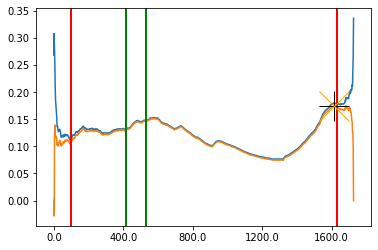

100%|████████████████████████████████████████████████████████████████████████████| 1196/1196 [00:00<00:00, 1320.34it/s]


Plot 21 - Embedding Perm 5 Error: -984.0000 sec.
LR accuracy on training: 0.9849624060150376
LR accuracy on downsampled training: 0.8482142857142857


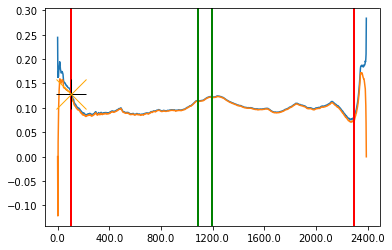

100%|████████████████████████████████████████████████████████████████████████████| 1240/1240 [00:01<00:00, 1045.43it/s]

Plot 22 - Embedding Perm 5 Error: 986.0000 sec.
LR accuracy on training: 0.9750201450443191
LR accuracy on downsampled training: 0.673469387755102


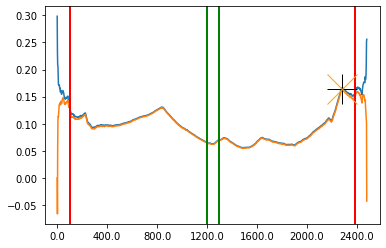

100%|████████████████████████████████████████████████████████████████████████████| 1173/1173 [00:00<00:00, 1525.31it/s]


Plot 23 - Embedding Perm 5 Error: -604.0000 sec.
LR accuracy on training: 0.9667802385008518
LR accuracy on downsampled training: 0.680327868852459


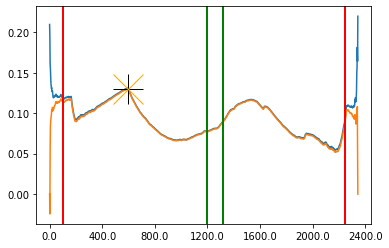

100%|████████████████████████████████████████████████████████████████████████████| 1224/1224 [00:00<00:00, 1379.06it/s]


Plot 24 - Embedding Perm 5 Error: 140.0000 sec.
LR accuracy on training: 0.9795918367346939
LR accuracy on downsampled training: 0.7796610169491526


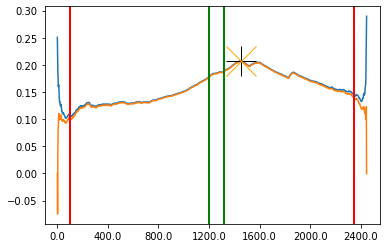

100%|████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 1339.92it/s]


Plot 25 - Embedding Perm 5 Error: 1058.0000 sec.
LR accuracy on training: 0.9925434962717481
LR accuracy on downsampled training: 0.5


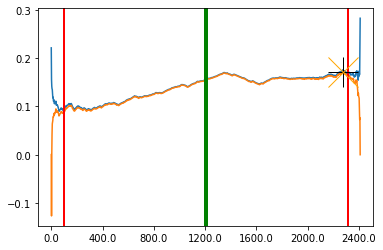

100%|████████████████████████████████████████████████████████████████████████████| 1204/1204 [00:00<00:00, 1526.70it/s]


Plot 26 - Embedding Perm 5 Error: -836.0000 sec.
LR accuracy on training: 0.9941908713692946
LR accuracy on downsampled training: 0.5


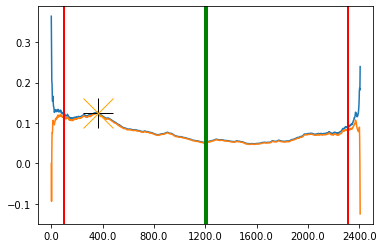

100%|██████████████████████████████████████████████████████████████████████████████| 858/858 [00:00<00:00, 3545.16it/s]


Plot 27 - Embedding Perm 5 Error: 66.0000 sec.
LR accuracy on training: 0.9906868451688009
LR accuracy on downsampled training: 0.5


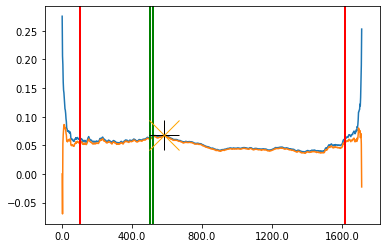

100%|██████████████████████████████████████████████████████████████████████████████| 663/663 [00:00<00:00, 5812.88it/s]


Plot 28 - Embedding Perm 5 Error: 8.0000 sec.
LR accuracy on training: 0.9894578313253012
LR accuracy on downsampled training: 0.5


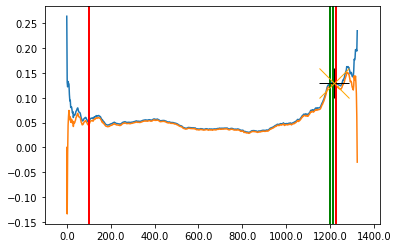

100%|████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 1479.81it/s]


Plot 29 - Embedding Perm 5 Error: -1100.0000 sec.
LR accuracy on training: 0.9925434962717481
LR accuracy on downsampled training: 0.5


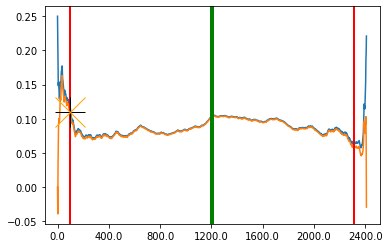

100%|████████████████████████████████████████████████████████████████████████████| 1241/1241 [00:00<00:00, 1460.78it/s]


Plot 30 - Embedding Perm 5 Error: 986.0000 sec.
LR accuracy on training: 0.9830917874396136
LR accuracy on downsampled training: 0.7613636363636364


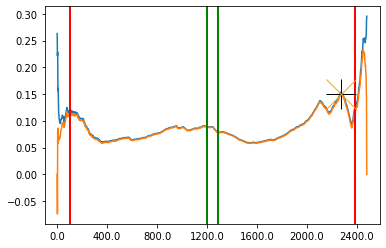

100%|██████████████████████████████████████████████████████████████████████████████| 819/819 [00:00<00:00, 3863.08it/s]


Plot 31 - Embedding Perm 5 Error: 34.0000 sec.
LR accuracy on training: 0.9646341463414634
LR accuracy on downsampled training: 0.6836734693877551


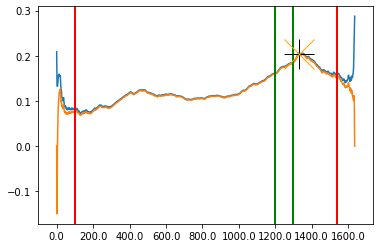

100%|██████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 2798.30it/s]


Plot 32 - Embedding Perm 5 Error: 50.0000 sec.
LR accuracy on training: 0.9542143600416233
LR accuracy on downsampled training: 0.6805555555555556


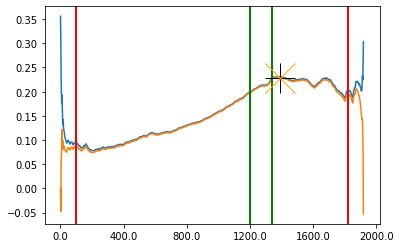

100%|████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:00<00:00, 2040.07it/s]


Plot 33 - Embedding Perm 5 Error: 592.0000 sec.
LR accuracy on training: 0.9398496240601504
LR accuracy on downsampled training: 0.6395348837209303


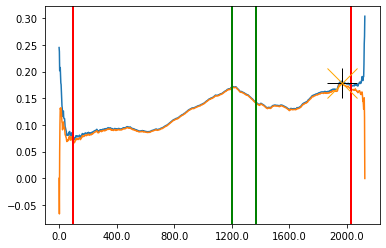

100%|██████████████████████████████████████████████████████████████████████████████| 970/970 [00:00<00:00, 2565.96it/s]


Plot 34 - Embedding Perm 5 Error: 208.0000 sec.
LR accuracy on training: 0.917610710607621
LR accuracy on downsampled training: 0.59375


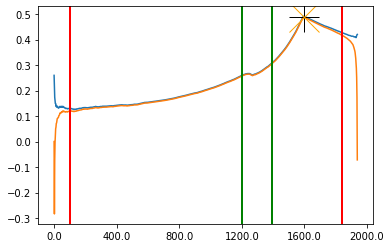

100%|██████████████████████████████████████████████████████████████████████████████| 904/904 [00:00<00:00, 2870.09it/s]


Plot 35 - Embedding Perm 5 Error: 0.0000 sec.
LR accuracy on training: 0.9425414364640884
LR accuracy on downsampled training: 0.6176470588235294


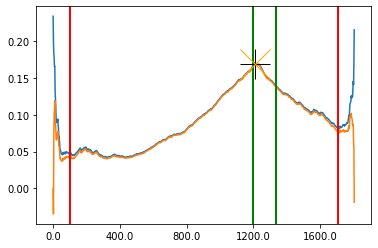

100%|████████████████████████████████████████████████████████████████████████████| 1190/1190 [00:00<00:00, 1533.58it/s]


Plot 36 - Embedding Perm 5 Error: -334.0000 sec.
LR accuracy on training: 0.9420654911838791
LR accuracy on downsampled training: 0.5802469135802469


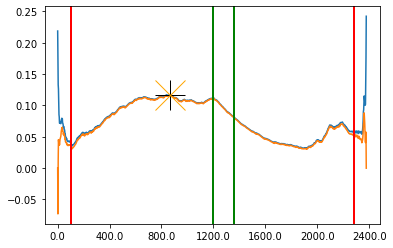

100%|█████████████████████████████████████████████████████████████████████████████| 1330/1330 [00:01<00:00, 908.69it/s]


Plot 37 - Embedding Perm 5 Error: 0.0000 sec.
LR accuracy on training: 0.9338842975206612
LR accuracy on downsampled training: 0.6691729323308271


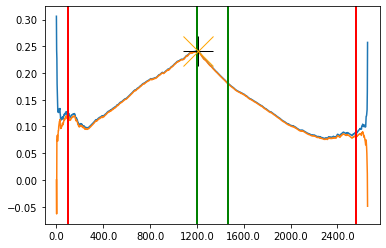

100%|████████████████████████████████████████████████████████████████████████████| 1230/1230 [00:00<00:00, 1294.74it/s]


Plot 38 - Embedding Perm 5 Error: 40.0000 sec.
LR accuracy on training: 0.9902518277822908
LR accuracy on downsampled training: 0.803030303030303


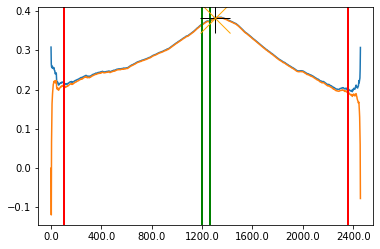

100%|██████████████████████████████████████████████████████████████████████████████| 799/799 [00:00<00:00, 3878.76it/s]


Plot 39 - Embedding Perm 5 Error: 176.0000 sec.
LR accuracy on training: 0.98375
LR accuracy on downsampled training: 0.78125


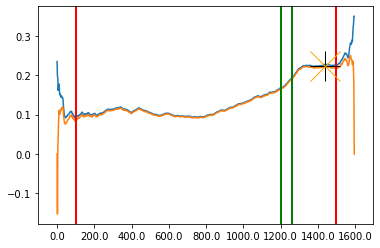

100%|████████████████████████████████████████████████████████████████████████████| 1042/1042 [00:00<00:00, 2214.36it/s]


Plot 40 - Embedding Perm 5 Error: 172.0000 sec.
LR accuracy on training: 0.9904122722914669
LR accuracy on downsampled training: 0.7222222222222222


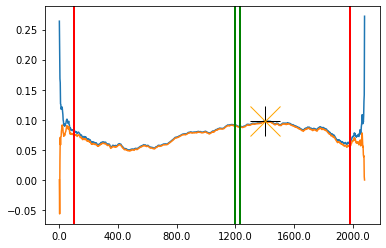

100%|██████████████████████████████████████████████████████████████████████████████| 760/760 [00:00<00:00, 4342.66it/s]


Plot 41 - Embedding Perm 5 Error: 0.0000 sec.
LR accuracy on training: 0.985545335085414
LR accuracy on downsampled training: 0.8055555555555556


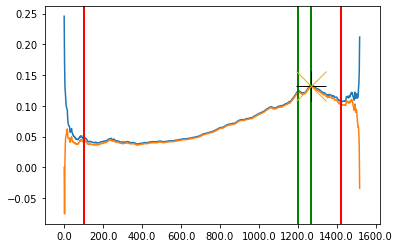

100%|████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:01<00:00, 1203.60it/s]


Plot 42 - Embedding Perm 5 Error: 898.0000 sec.
LR accuracy on training: 0.989448051948052
LR accuracy on downsampled training: 0.803030303030303


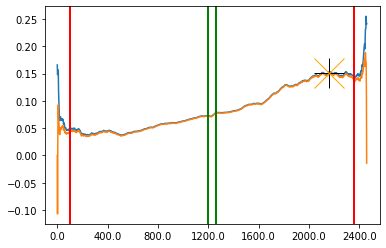

100%|████████████████████████████████████████████████████████████████████████████| 1227/1227 [00:00<00:00, 1422.89it/s]


Plot 43 - Embedding Perm 5 Error: 124.0000 sec.
LR accuracy on training: 0.991042345276873
LR accuracy on downsampled training: 0.8


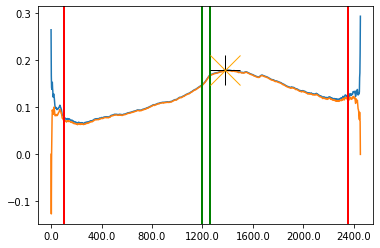

100%|████████████████████████████████████████████████████████████████████████████| 1236/1236 [00:01<00:00, 1080.23it/s]


Plot 44 - Embedding Perm 5 Error: -946.0000 sec.
LR accuracy on training: 0.9870654810024252
LR accuracy on downsampled training: 0.782051282051282


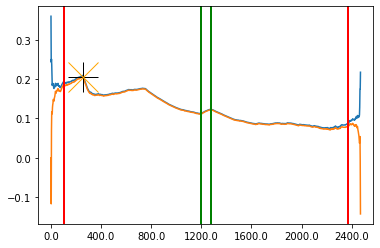

100%|████████████████████████████████████████████████████████████████████████████| 1243/1243 [00:01<00:00, 1234.31it/s]


Plot 45 - Embedding Perm 5 Error: 842.0000 sec.
LR accuracy on training: 0.9790996784565916
LR accuracy on downsampled training: 0.7111111111111111


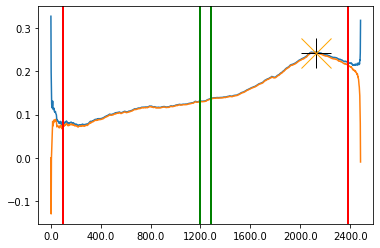

100%|████████████████████████████████████████████████████████████████████████████| 1225/1225 [00:00<00:00, 1260.27it/s]


Plot 46 - Embedding Perm 5 Error: 202.0000 sec.
LR accuracy on training: 0.9836867862969005
LR accuracy on downsampled training: 0.6428571428571429


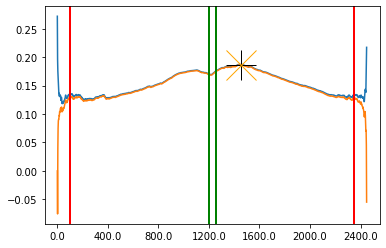

Total accuracy: 0.1702127659574468
LR accuracy on validation: 0.9822419533851277
LR accuracy on downsampled validation: [0.6190476190476191, 0.6190476190476191, 0.6190476190476191]


C:\Users\djnak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [12]:
main(emb=5)

100%|██████████████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 2846.16it/s]


Plot 1 - Embedding Perm 6 Error: 0.0000 sec.
LR accuracy on training: 0.9822419533851277
LR accuracy on downsampled training: 0.6190476190476191


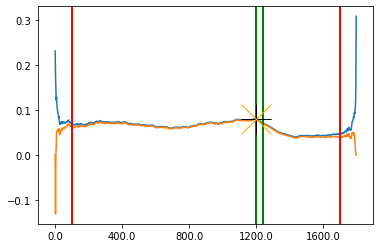

100%|████████████████████████████████████████████████████████████████████████████| 1212/1212 [00:00<00:00, 1345.13it/s]


Plot 2 - Embedding Perm 6 Error: -1100.0000 sec.
LR accuracy on training: 0.9901071723000825
LR accuracy on downsampled training: 0.5714285714285714


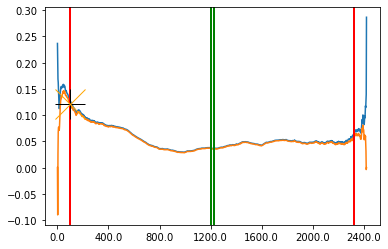

100%|████████████████████████████████████████████████████████████████████████████| 1218/1218 [00:00<00:00, 1447.27it/s]


Plot 3 - Embedding Perm 6 Error: 32.0000 sec.
LR accuracy on training: 0.985233798195242
LR accuracy on downsampled training: 0.5714285714285714


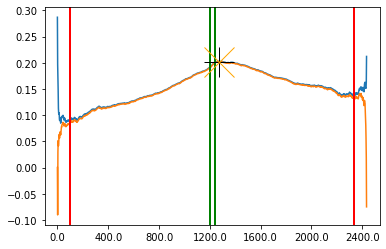

100%|████████████████████████████████████████████████████████████████████████████| 1131/1131 [00:00<00:00, 1713.63it/s]


Plot 4 - Embedding Perm 6 Error: -896.0000 sec.
LR accuracy on training: 0.9840989399293286
LR accuracy on downsampled training: 0.6538461538461539


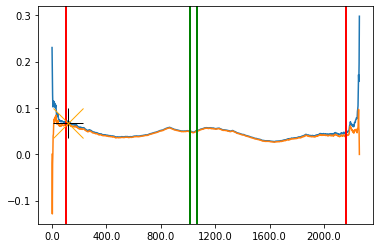

100%|████████████████████████████████████████████████████████████████████████████| 1243/1243 [00:00<00:00, 1417.33it/s]


Plot 5 - Embedding Perm 6 Error: 1086.0000 sec.
LR accuracy on training: 0.9815112540192926
LR accuracy on downsampled training: 0.75


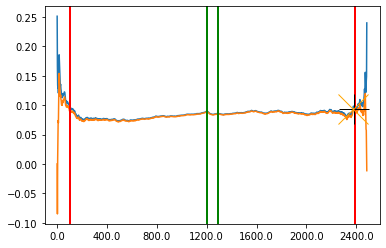

100%|██████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 3847.66it/s]


Plot 6 - Embedding Perm 6 Error: -226.0000 sec.
LR accuracy on training: 0.9765142150803461
LR accuracy on downsampled training: 0.7553191489361702


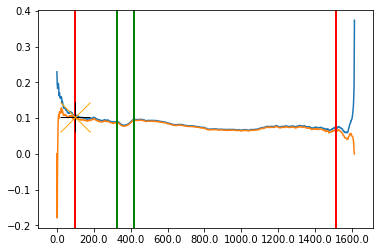

100%|██████████████████████████████████████████████████████████████████████████████| 830/830 [00:00<00:00, 3705.39it/s]


Plot 7 - Embedding Perm 6 Error: -860.0000 sec.
LR accuracy on training: 0.9711191335740073
LR accuracy on downsampled training: 0.7450980392156863


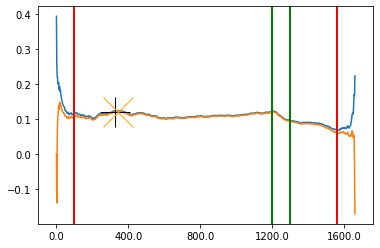

100%|██████████████████████████████████████████████████████████████████████████████| 478/478 [00:00<00:00, 9558.14it/s]

Plot 8 - Embedding Perm 6 Error: 0.0000 sec.
LR accuracy on training: 0.9102296450939458
LR accuracy on downsampled training: 0.4880952380952381


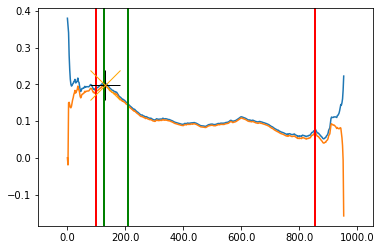

100%|██████████████████████████████████████████████████████████████████████████████| 912/912 [00:00<00:00, 3070.48it/s]

Plot 9 - Embedding Perm 6 Error: 0.0000 sec.
LR accuracy on training: 0.9550930996714129
LR accuracy on downsampled training: 0.5


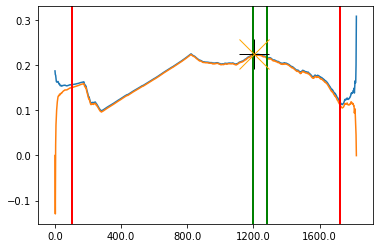

100%|██████████████████████████████████████████████████████████████████████████████| 714/714 [00:00<00:00, 4956.17it/s]


Plot 10 - Embedding Perm 6 Error: -154.0000 sec.
LR accuracy on training: 0.993006993006993
LR accuracy on downsampled training: 0.5


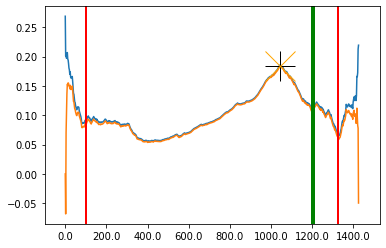

100%|██████████████████████████████████████████████████████████████████████████████| 805/805 [00:00<00:00, 3889.14it/s]


Plot 11 - Embedding Perm 6 Error: -176.0000 sec.
LR accuracy on training: 0.966501240694789
LR accuracy on downsampled training: 0.5


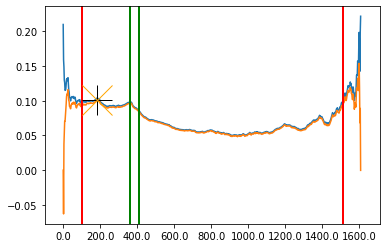

100%|██████████████████████████████████████████████████████████████████████████████| 996/996 [00:00<00:00, 2547.31it/s]


Plot 12 - Embedding Perm 6 Error: -64.0000 sec.
LR accuracy on training: 0.9729187562688064
LR accuracy on downsampled training: 0.6060606060606061


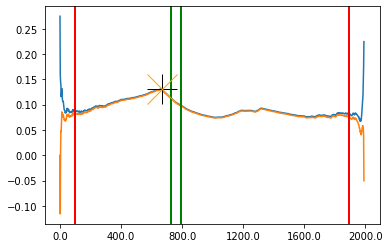

100%|██████████████████████████████████████████████████████████████████████████████| 849/849 [00:00<00:00, 3582.33it/s]


Plot 13 - Embedding Perm 6 Error: 1032.0000 sec.
LR accuracy on training: 0.9588235294117647
LR accuracy on downsampled training: 0.5138888888888888


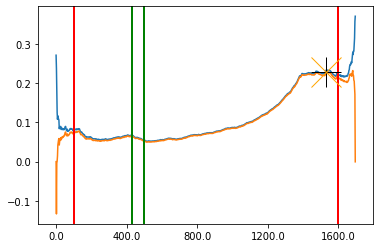

100%|████████████████████████████████████████████████████████████████████████████| 1224/1224 [00:00<00:00, 1505.17it/s]


Plot 14 - Embedding Perm 6 Error: 1094.0000 sec.
LR accuracy on training: 0.9771428571428571
LR accuracy on downsampled training: 0.5370370370370371


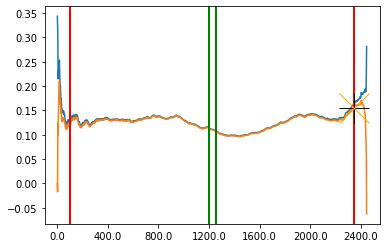

100%|████████████████████████████████████████████████████████████████████████████| 1222/1222 [00:00<00:00, 1516.78it/s]


Plot 15 - Embedding Perm 6 Error: -38.0000 sec.
LR accuracy on training: 0.9803761242845462
LR accuracy on downsampled training: 0.5208333333333334


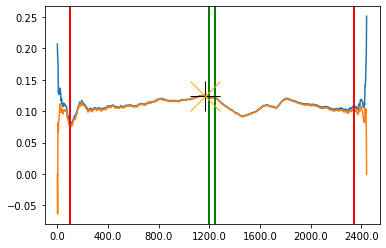

100%|████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 1947.00it/s]


Plot 16 - Embedding Perm 6 Error: -478.0000 sec.
LR accuracy on training: 0.9682683590208522
LR accuracy on downsampled training: 0.5151515151515151


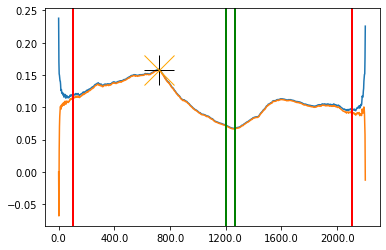

100%|████████████████████████████████████████████████████████████████████████████| 1225/1225 [00:00<00:00, 1465.38it/s]


Plot 17 - Embedding Perm 6 Error: 0.0000 sec.
LR accuracy on training: 0.9771615008156607
LR accuracy on downsampled training: 0.5


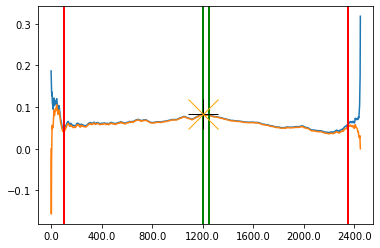

100%|████████████████████████████████████████████████████████████████████████████| 1223/1223 [00:00<00:00, 1540.31it/s]


Plot 18 - Embedding Perm 6 Error: -452.0000 sec.
LR accuracy on training: 0.9795751633986928
LR accuracy on downsampled training: 0.5


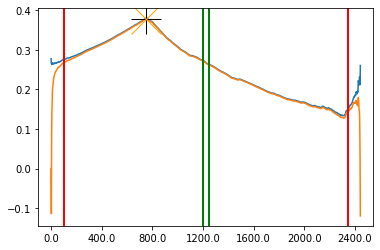

100%|████████████████████████████████████████████████████████████████████████████| 1254/1254 [00:00<00:00, 1407.41it/s]


Plot 19 - Embedding Perm 6 Error: 1094.0000 sec.
LR accuracy on training: 0.9553784860557769
LR accuracy on downsampled training: 0.5


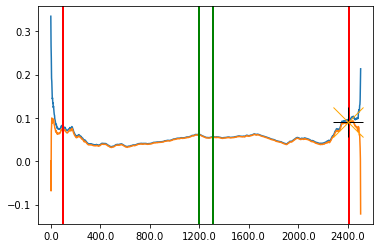

100%|██████████████████████████████████████████████████████████████████████████████| 864/864 [00:00<00:00, 3010.17it/s]


Plot 20 - Embedding Perm 6 Error: 1084.0000 sec.
LR accuracy on training: 0.9849710982658959
LR accuracy on downsampled training: 0.853448275862069


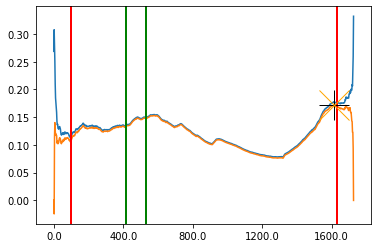

100%|████████████████████████████████████████████████████████████████████████████| 1196/1196 [00:01<00:00, 1087.20it/s]


Plot 21 - Embedding Perm 6 Error: -984.0000 sec.
LR accuracy on training: 0.9849624060150376
LR accuracy on downsampled training: 0.8482142857142857


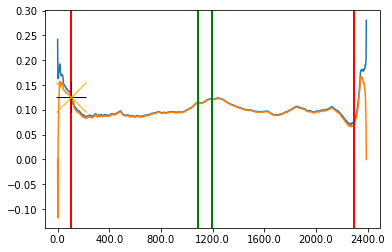

100%|████████████████████████████████████████████████████████████████████████████| 1240/1240 [00:00<00:00, 1301.09it/s]


Plot 22 - Embedding Perm 6 Error: 986.0000 sec.
LR accuracy on training: 0.9750201450443191
LR accuracy on downsampled training: 0.673469387755102


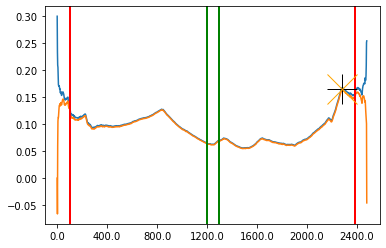

100%|████████████████████████████████████████████████████████████████████████████| 1173/1173 [00:00<00:00, 1500.72it/s]


Plot 23 - Embedding Perm 6 Error: 212.0000 sec.
LR accuracy on training: 0.9667802385008518
LR accuracy on downsampled training: 0.6475409836065574


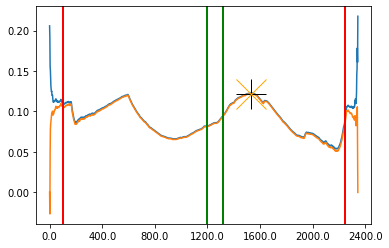

100%|████████████████████████████████████████████████████████████████████████████| 1224/1224 [00:00<00:00, 1524.15it/s]


Plot 24 - Embedding Perm 6 Error: 140.0000 sec.
LR accuracy on training: 0.9795918367346939
LR accuracy on downsampled training: 0.7966101694915254


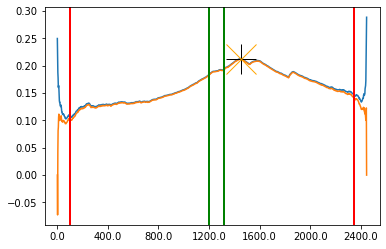

100%|████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:01<00:00, 1181.10it/s]


Plot 25 - Embedding Perm 6 Error: 1058.0000 sec.
LR accuracy on training: 0.9925434962717481
LR accuracy on downsampled training: 0.5


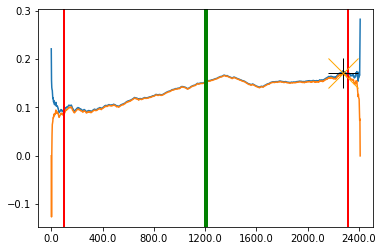

100%|████████████████████████████████████████████████████████████████████████████| 1204/1204 [00:00<00:00, 1545.58it/s]


Plot 26 - Embedding Perm 6 Error: -836.0000 sec.
LR accuracy on training: 0.9941908713692946
LR accuracy on downsampled training: 0.5


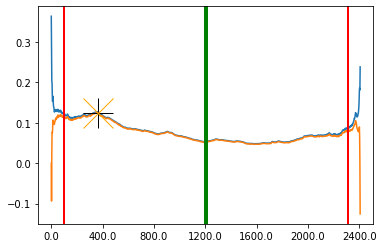

100%|██████████████████████████████████████████████████████████████████████████████| 858/858 [00:00<00:00, 3473.72it/s]


Plot 27 - Embedding Perm 6 Error: 66.0000 sec.
LR accuracy on training: 0.9906868451688009
LR accuracy on downsampled training: 0.5


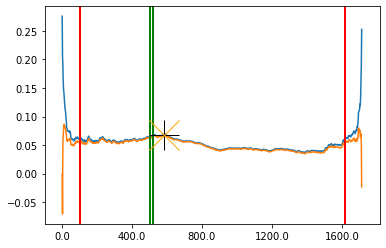

100%|██████████████████████████████████████████████████████████████████████████████| 663/663 [00:00<00:00, 5715.54it/s]


Plot 28 - Embedding Perm 6 Error: 8.0000 sec.
LR accuracy on training: 0.9894578313253012
LR accuracy on downsampled training: 0.5


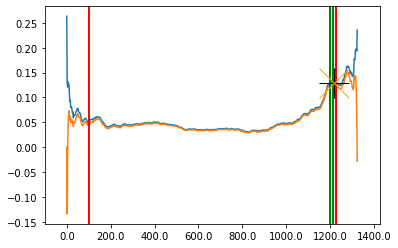

100%|████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:01<00:00, 1137.54it/s]


Plot 29 - Embedding Perm 6 Error: -1100.0000 sec.
LR accuracy on training: 0.9925434962717481
LR accuracy on downsampled training: 0.5


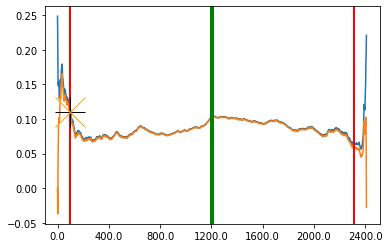

100%|████████████████████████████████████████████████████████████████████████████| 1241/1241 [00:01<00:00, 1159.83it/s]


Plot 30 - Embedding Perm 6 Error: 982.0000 sec.
LR accuracy on training: 0.9830917874396136
LR accuracy on downsampled training: 0.7727272727272727


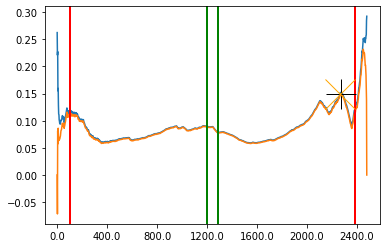

100%|██████████████████████████████████████████████████████████████████████████████| 819/819 [00:00<00:00, 3639.86it/s]


Plot 31 - Embedding Perm 6 Error: 34.0000 sec.
LR accuracy on training: 0.9646341463414634
LR accuracy on downsampled training: 0.6836734693877551


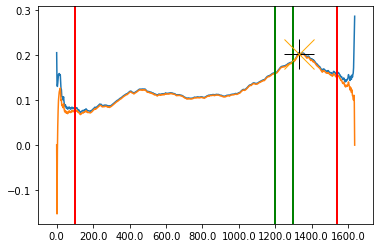

100%|██████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 1927.87it/s]


Plot 32 - Embedding Perm 6 Error: 6.0000 sec.
LR accuracy on training: 0.9542143600416233
LR accuracy on downsampled training: 0.6805555555555556


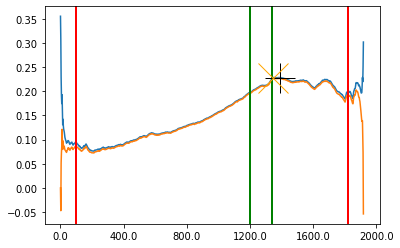

100%|████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:00<00:00, 2219.17it/s]


Plot 33 - Embedding Perm 6 Error: 592.0000 sec.
LR accuracy on training: 0.9398496240601504
LR accuracy on downsampled training: 0.6162790697674418


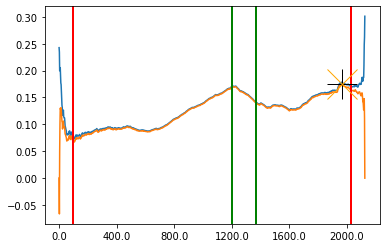

100%|██████████████████████████████████████████████████████████████████████████████| 970/970 [00:00<00:00, 2125.25it/s]


Plot 34 - Embedding Perm 6 Error: 208.0000 sec.
LR accuracy on training: 0.917610710607621
LR accuracy on downsampled training: 0.5833333333333334


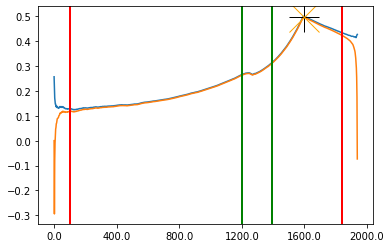

100%|██████████████████████████████████████████████████████████████████████████████| 904/904 [00:00<00:00, 2711.25it/s]


Plot 35 - Embedding Perm 6 Error: 0.0000 sec.
LR accuracy on training: 0.9425414364640884
LR accuracy on downsampled training: 0.6102941176470589


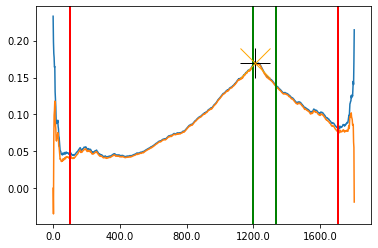

100%|████████████████████████████████████████████████████████████████████████████| 1190/1190 [00:00<00:00, 1447.92it/s]


Plot 36 - Embedding Perm 6 Error: -334.0000 sec.
LR accuracy on training: 0.9420654911838791
LR accuracy on downsampled training: 0.5617283950617284


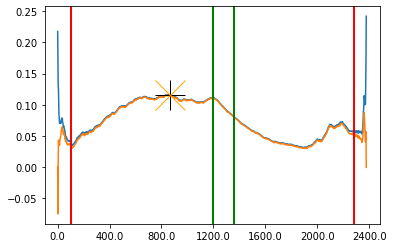

100%|█████████████████████████████████████████████████████████████████████████████| 1330/1330 [00:01<00:00, 939.15it/s]


Plot 37 - Embedding Perm 6 Error: 0.0000 sec.
LR accuracy on training: 0.9338842975206612
LR accuracy on downsampled training: 0.6541353383458647


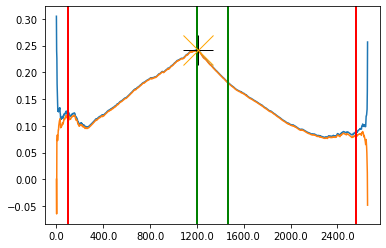

100%|████████████████████████████████████████████████████████████████████████████| 1230/1230 [00:01<00:00, 1137.81it/s]


Plot 38 - Embedding Perm 6 Error: 40.0000 sec.
LR accuracy on training: 0.9894394800974817
LR accuracy on downsampled training: 0.803030303030303


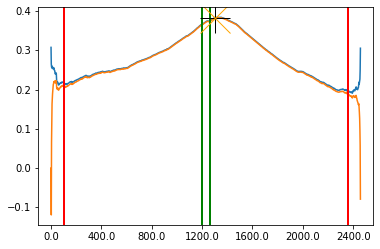

100%|██████████████████████████████████████████████████████████████████████████████| 799/799 [00:00<00:00, 3698.61it/s]


Plot 39 - Embedding Perm 6 Error: 176.0000 sec.
LR accuracy on training: 0.98375
LR accuracy on downsampled training: 0.796875


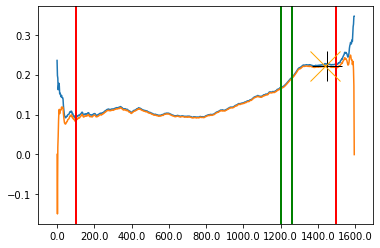

100%|████████████████████████████████████████████████████████████████████████████| 1042/1042 [00:00<00:00, 2015.48it/s]


Plot 40 - Embedding Perm 6 Error: 172.0000 sec.
LR accuracy on training: 0.9904122722914669
LR accuracy on downsampled training: 0.7222222222222222


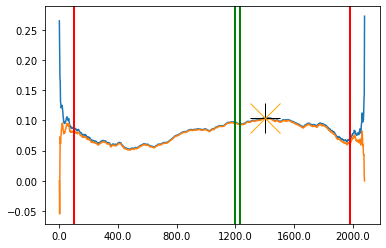

100%|██████████████████████████████████████████████████████████████████████████████| 760/760 [00:00<00:00, 4091.20it/s]


Plot 41 - Embedding Perm 6 Error: 0.0000 sec.
LR accuracy on training: 0.985545335085414
LR accuracy on downsampled training: 0.8194444444444444


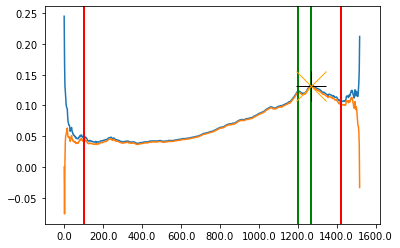

100%|████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:01<00:00, 1046.77it/s]


Plot 42 - Embedding Perm 6 Error: 898.0000 sec.
LR accuracy on training: 0.989448051948052
LR accuracy on downsampled training: 0.803030303030303


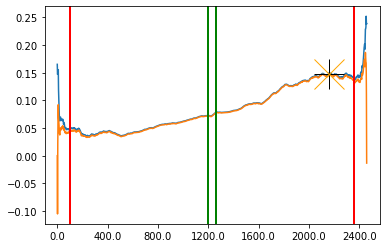

100%|█████████████████████████████████████████████████████████████████████████████| 1227/1227 [00:01<00:00, 956.27it/s]


Plot 43 - Embedding Perm 6 Error: 124.0000 sec.
LR accuracy on training: 0.990228013029316
LR accuracy on downsampled training: 0.8


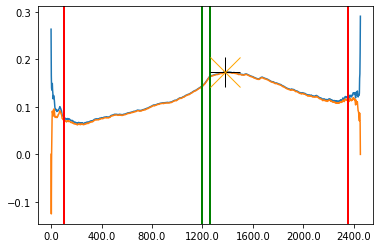

100%|████████████████████████████████████████████████████████████████████████████| 1236/1236 [00:01<00:00, 1120.86it/s]


Plot 44 - Embedding Perm 6 Error: -946.0000 sec.
LR accuracy on training: 0.9870654810024252
LR accuracy on downsampled training: 0.7948717948717948


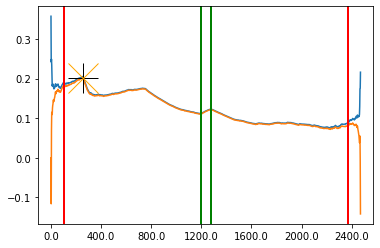

100%|████████████████████████████████████████████████████████████████████████████| 1243/1243 [00:00<00:00, 1274.10it/s]


Plot 45 - Embedding Perm 6 Error: 842.0000 sec.
LR accuracy on training: 0.9790996784565916
LR accuracy on downsampled training: 0.7


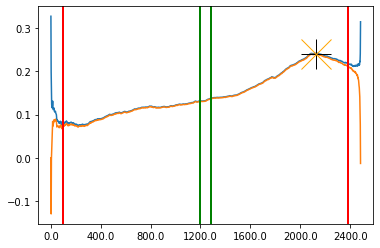

100%|████████████████████████████████████████████████████████████████████████████| 1225/1225 [00:00<00:00, 1391.12it/s]


Plot 46 - Embedding Perm 6 Error: 182.0000 sec.
LR accuracy on training: 0.9836867862969005
LR accuracy on downsampled training: 0.6428571428571429


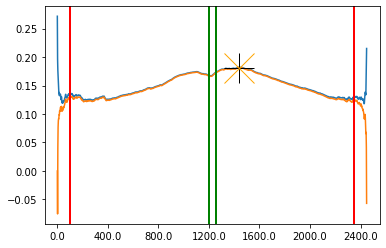

Total accuracy: 0.14893617021276595
LR accuracy on validation: 0.9822419533851277
LR accuracy on downsampled validation: [0.6190476190476191, 0.6190476190476191, 0.6190476190476191, 0.6190476190476191]


C:\Users\djnak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [13]:
main(emb=6)

100%|██████████████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 3092.46it/s]


Plot 1 - Embedding Perm 7 Error: 0.0000 sec.
LR accuracy on training: 0.9822419533851277
LR accuracy on downsampled training: 0.6190476190476191


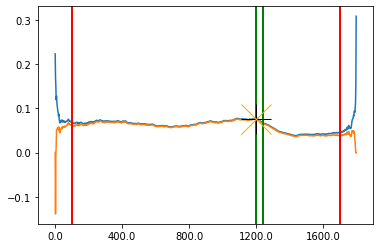

100%|████████████████████████████████████████████████████████████████████████████| 1212/1212 [00:00<00:00, 1336.73it/s]


Plot 2 - Embedding Perm 7 Error: -1100.0000 sec.
LR accuracy on training: 0.9901071723000825
LR accuracy on downsampled training: 0.5714285714285714


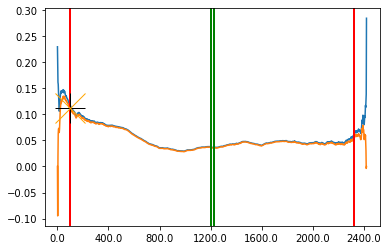

100%|████████████████████████████████████████████████████████████████████████████| 1218/1218 [00:01<00:00, 1169.47it/s]


Plot 3 - Embedding Perm 7 Error: 32.0000 sec.
LR accuracy on training: 0.985233798195242
LR accuracy on downsampled training: 0.5714285714285714


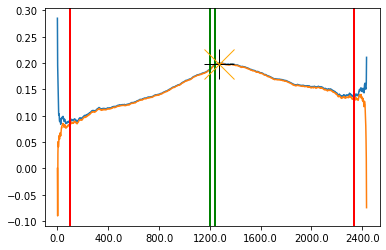

100%|████████████████████████████████████████████████████████████████████████████| 1131/1131 [00:00<00:00, 1596.46it/s]


Plot 4 - Embedding Perm 7 Error: -896.0000 sec.
LR accuracy on training: 0.9832155477031802
LR accuracy on downsampled training: 0.6346153846153846


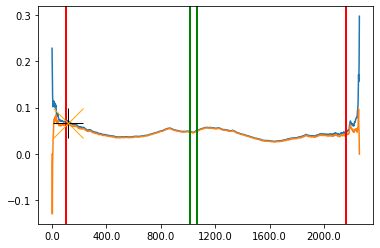

100%|████████████████████████████████████████████████████████████████████████████| 1243/1243 [00:00<00:00, 1381.24it/s]


Plot 5 - Embedding Perm 7 Error: 1086.0000 sec.
LR accuracy on training: 0.9815112540192926
LR accuracy on downsampled training: 0.75


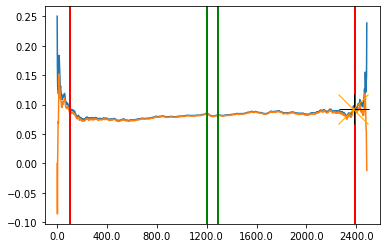

100%|██████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 3841.02it/s]


Plot 6 - Embedding Perm 7 Error: -226.0000 sec.
LR accuracy on training: 0.9752781211372065
LR accuracy on downsampled training: 0.7872340425531915


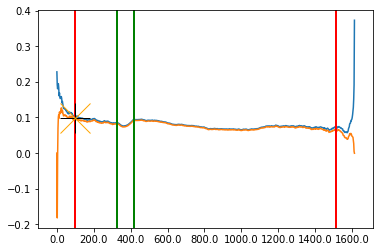

100%|██████████████████████████████████████████████████████████████████████████████| 830/830 [00:00<00:00, 3479.24it/s]


Plot 7 - Embedding Perm 7 Error: -860.0000 sec.
LR accuracy on training: 0.9699157641395909
LR accuracy on downsampled training: 0.7450980392156863


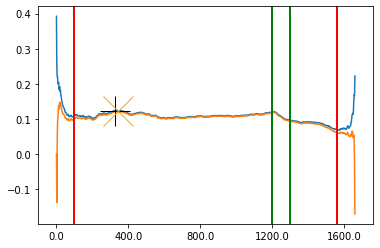

100%|██████████████████████████████████████████████████████████████████████████████| 478/478 [00:00<00:00, 9139.83it/s]

Plot 8 - Embedding Perm 7 Error: 0.0000 sec.
LR accuracy on training: 0.9102296450939458
LR accuracy on downsampled training: 0.5


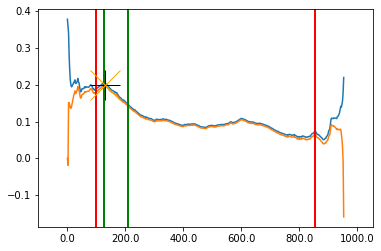

100%|██████████████████████████████████████████████████████████████████████████████| 912/912 [00:00<00:00, 2788.42it/s]


Plot 9 - Embedding Perm 7 Error: -378.0000 sec.
LR accuracy on training: 0.9550930996714129
LR accuracy on downsampled training: 0.5


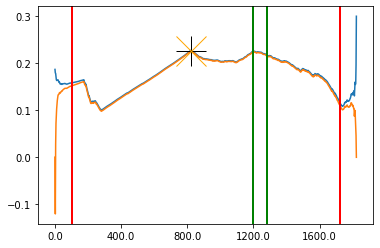

100%|██████████████████████████████████████████████████████████████████████████████| 714/714 [00:00<00:00, 4942.28it/s]


Plot 10 - Embedding Perm 7 Error: -154.0000 sec.
LR accuracy on training: 0.993006993006993
LR accuracy on downsampled training: 0.5


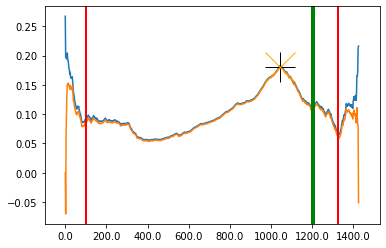

100%|██████████████████████████████████████████████████████████████████████████████| 805/805 [00:00<00:00, 3870.20it/s]


Plot 11 - Embedding Perm 7 Error: 0.0000 sec.
LR accuracy on training: 0.966501240694789
LR accuracy on downsampled training: 0.5


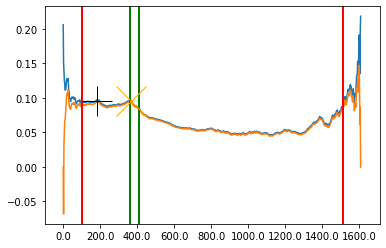

100%|██████████████████████████████████████████████████████████████████████████████| 996/996 [00:00<00:00, 2404.81it/s]


Plot 12 - Embedding Perm 7 Error: -64.0000 sec.
LR accuracy on training: 0.9729187562688064
LR accuracy on downsampled training: 0.5909090909090909


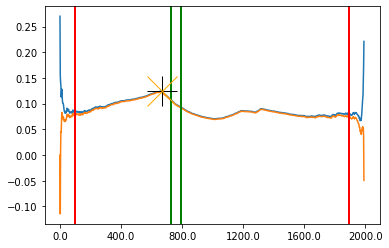

100%|██████████████████████████████████████████████████████████████████████████████| 849/849 [00:00<00:00, 3191.40it/s]


Plot 13 - Embedding Perm 7 Error: 1032.0000 sec.
LR accuracy on training: 0.9588235294117647
LR accuracy on downsampled training: 0.5138888888888888


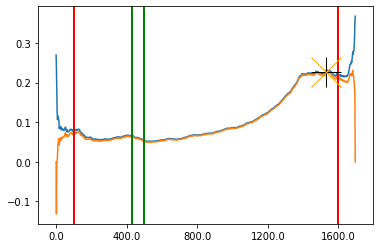

100%|████████████████████████████████████████████████████████████████████████████| 1224/1224 [00:00<00:00, 1303.32it/s]


Plot 14 - Embedding Perm 7 Error: 1094.0000 sec.
LR accuracy on training: 0.9771428571428571
LR accuracy on downsampled training: 0.5555555555555556


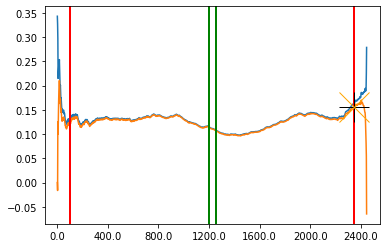

100%|████████████████████████████████████████████████████████████████████████████| 1222/1222 [00:01<00:00, 1184.40it/s]


Plot 15 - Embedding Perm 7 Error: -382.0000 sec.
LR accuracy on training: 0.9803761242845462
LR accuracy on downsampled training: 0.5208333333333334


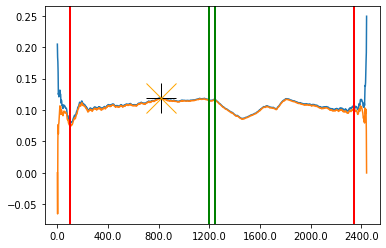

100%|████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 1920.76it/s]


Plot 16 - Embedding Perm 7 Error: -478.0000 sec.
LR accuracy on training: 0.9682683590208522
LR accuracy on downsampled training: 0.5151515151515151


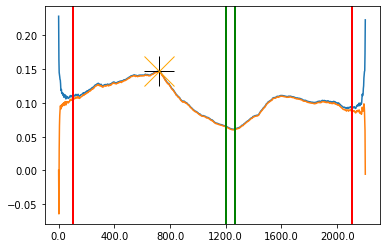

100%|████████████████████████████████████████████████████████████████████████████| 1225/1225 [00:00<00:00, 1359.60it/s]


Plot 17 - Embedding Perm 7 Error: 0.0000 sec.
LR accuracy on training: 0.9771615008156607
LR accuracy on downsampled training: 0.5


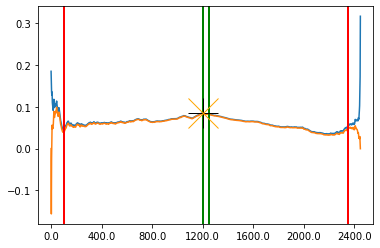

100%|████████████████████████████████████████████████████████████████████████████| 1223/1223 [00:00<00:00, 1232.32it/s]


Plot 18 - Embedding Perm 7 Error: -452.0000 sec.
LR accuracy on training: 0.9795751633986928
LR accuracy on downsampled training: 0.5


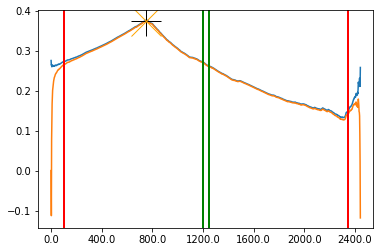

100%|████████████████████████████████████████████████████████████████████████████| 1254/1254 [00:00<00:00, 1319.37it/s]


Plot 19 - Embedding Perm 7 Error: 1094.0000 sec.
LR accuracy on training: 0.9553784860557769
LR accuracy on downsampled training: 0.5


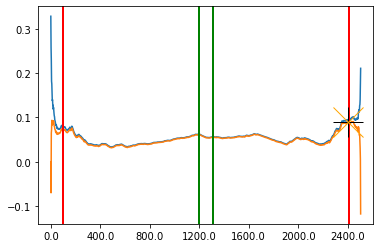

100%|██████████████████████████████████████████████████████████████████████████████| 864/864 [00:00<00:00, 3348.96it/s]


Plot 20 - Embedding Perm 7 Error: 1084.0000 sec.
LR accuracy on training: 0.9849710982658959
LR accuracy on downsampled training: 0.8620689655172413


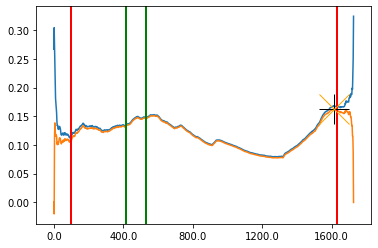

100%|████████████████████████████████████████████████████████████████████████████| 1196/1196 [00:00<00:00, 1507.72it/s]


Plot 21 - Embedding Perm 7 Error: 46.0000 sec.
LR accuracy on training: 0.9849624060150376
LR accuracy on downsampled training: 0.8303571428571429


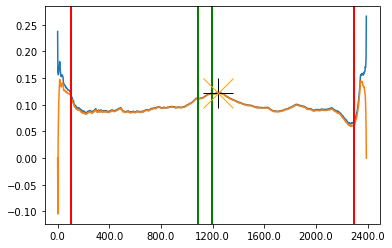

100%|████████████████████████████████████████████████████████████████████████████| 1240/1240 [00:00<00:00, 1267.78it/s]


Plot 22 - Embedding Perm 7 Error: 986.0000 sec.
LR accuracy on training: 0.9750201450443191
LR accuracy on downsampled training: 0.6632653061224489


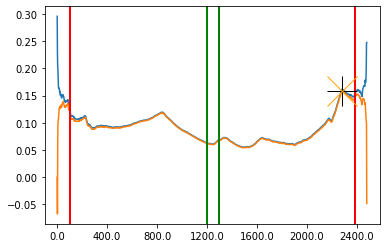

100%|████████████████████████████████████████████████████████████████████████████| 1173/1173 [00:00<00:00, 1511.54it/s]


Plot 23 - Embedding Perm 7 Error: 212.0000 sec.
LR accuracy on training: 0.9676320272572402
LR accuracy on downsampled training: 0.680327868852459


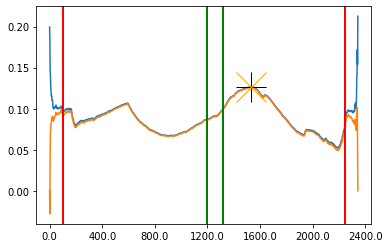

100%|████████████████████████████████████████████████████████████████████████████| 1224/1224 [00:00<00:00, 1380.30it/s]


Plot 24 - Embedding Perm 7 Error: 140.0000 sec.
LR accuracy on training: 0.9795918367346939
LR accuracy on downsampled training: 0.788135593220339


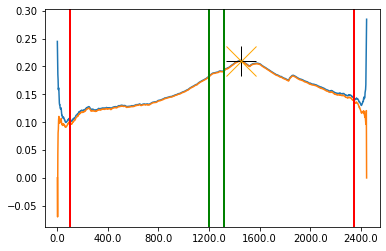

100%|████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 1473.28it/s]


Plot 25 - Embedding Perm 7 Error: 1058.0000 sec.
LR accuracy on training: 0.9925434962717481
LR accuracy on downsampled training: 0.5


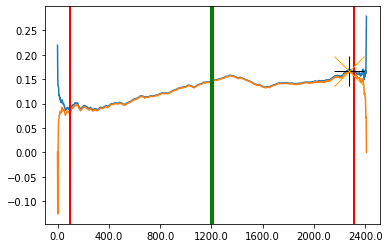

100%|████████████████████████████████████████████████████████████████████████████| 1204/1204 [00:00<00:00, 1467.84it/s]


Plot 26 - Embedding Perm 7 Error: -836.0000 sec.
LR accuracy on training: 0.9941908713692946
LR accuracy on downsampled training: 0.5


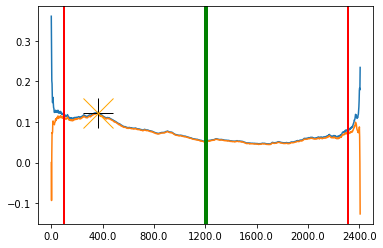

100%|██████████████████████████████████████████████████████████████████████████████| 858/858 [00:00<00:00, 3250.97it/s]


Plot 27 - Embedding Perm 7 Error: 66.0000 sec.
LR accuracy on training: 0.9906868451688009
LR accuracy on downsampled training: 0.5


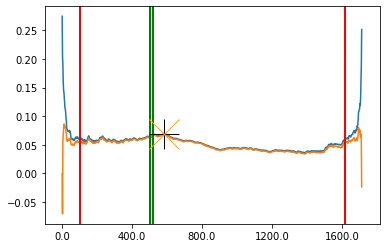

100%|██████████████████████████████████████████████████████████████████████████████| 663/663 [00:00<00:00, 5716.79it/s]


Plot 28 - Embedding Perm 7 Error: 8.0000 sec.
LR accuracy on training: 0.9894578313253012
LR accuracy on downsampled training: 0.5


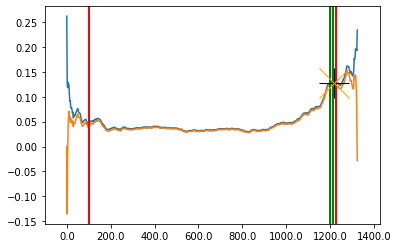

100%|████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:01<00:00, 1186.26it/s]


Plot 29 - Embedding Perm 7 Error: -1100.0000 sec.
LR accuracy on training: 0.9925434962717481
LR accuracy on downsampled training: 0.5


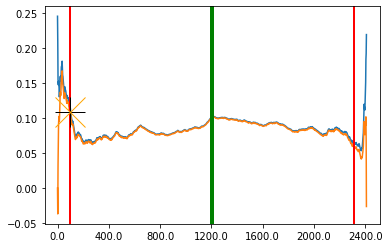

100%|████████████████████████████████████████████████████████████████████████████| 1241/1241 [00:00<00:00, 1302.47it/s]


Plot 30 - Embedding Perm 7 Error: 982.0000 sec.
LR accuracy on training: 0.9830917874396136
LR accuracy on downsampled training: 0.7613636363636364


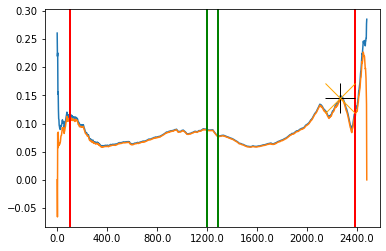

100%|██████████████████████████████████████████████████████████████████████████████| 819/819 [00:00<00:00, 3791.52it/s]


Plot 31 - Embedding Perm 7 Error: 34.0000 sec.
LR accuracy on training: 0.9646341463414634
LR accuracy on downsampled training: 0.6836734693877551


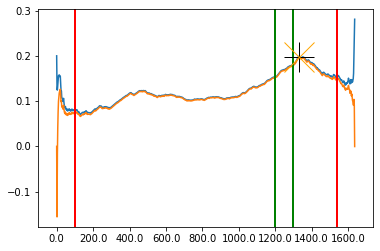

100%|██████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 2633.67it/s]


Plot 32 - Embedding Perm 7 Error: 6.0000 sec.
LR accuracy on training: 0.9542143600416233
LR accuracy on downsampled training: 0.6666666666666666


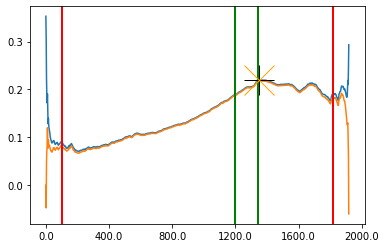

100%|████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:00<00:00, 1795.59it/s]


Plot 33 - Embedding Perm 7 Error: 0.0000 sec.
LR accuracy on training: 0.9389097744360902
LR accuracy on downsampled training: 0.6395348837209303


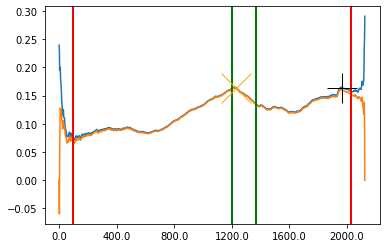

100%|██████████████████████████████████████████████████████████████████████████████| 970/970 [00:00<00:00, 2483.05it/s]


Plot 34 - Embedding Perm 7 Error: 208.0000 sec.
LR accuracy on training: 0.917610710607621
LR accuracy on downsampled training: 0.5885416666666666


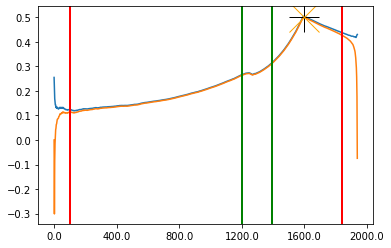

100%|██████████████████████████████████████████████████████████████████████████████| 904/904 [00:00<00:00, 2575.34it/s]


Plot 35 - Embedding Perm 7 Error: 0.0000 sec.
LR accuracy on training: 0.9425414364640884
LR accuracy on downsampled training: 0.6029411764705882


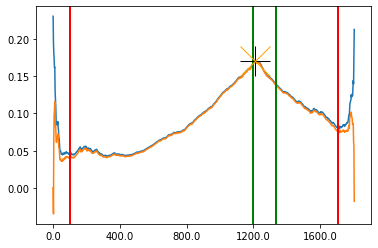

100%|████████████████████████████████████████████████████████████████████████████| 1190/1190 [00:00<00:00, 1501.00it/s]


Plot 36 - Embedding Perm 7 Error: -334.0000 sec.
LR accuracy on training: 0.9420654911838791
LR accuracy on downsampled training: 0.5802469135802469


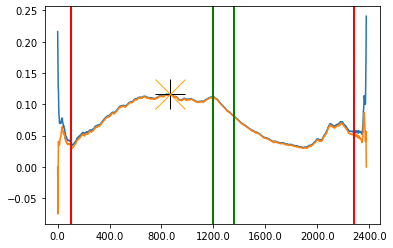

100%|█████████████████████████████████████████████████████████████████████████████| 1330/1330 [00:01<00:00, 964.74it/s]


Plot 37 - Embedding Perm 7 Error: 0.0000 sec.
LR accuracy on training: 0.9331329827197595
LR accuracy on downsampled training: 0.6766917293233082


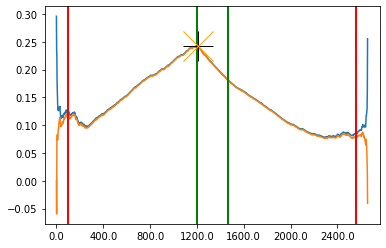

100%|████████████████████████████████████████████████████████████████████████████| 1230/1230 [00:00<00:00, 1335.58it/s]


Plot 38 - Embedding Perm 7 Error: 40.0000 sec.
LR accuracy on training: 0.9894394800974817
LR accuracy on downsampled training: 0.803030303030303


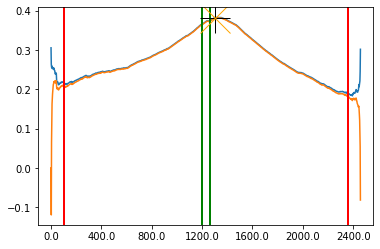

100%|██████████████████████████████████████████████████████████████████████████████| 799/799 [00:00<00:00, 3803.42it/s]


Plot 39 - Embedding Perm 7 Error: 176.0000 sec.
LR accuracy on training: 0.98375
LR accuracy on downsampled training: 0.78125


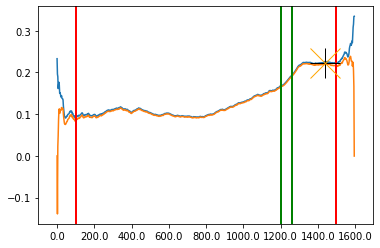

100%|████████████████████████████████████████████████████████████████████████████| 1042/1042 [00:00<00:00, 2075.58it/s]


Plot 40 - Embedding Perm 7 Error: 172.0000 sec.
LR accuracy on training: 0.9904122722914669
LR accuracy on downsampled training: 0.7222222222222222


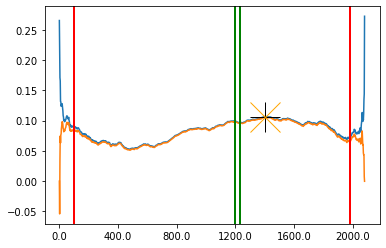

100%|██████████████████████████████████████████████████████████████████████████████| 760/760 [00:00<00:00, 4497.12it/s]


Plot 41 - Embedding Perm 7 Error: 0.0000 sec.
LR accuracy on training: 0.985545335085414
LR accuracy on downsampled training: 0.8333333333333334


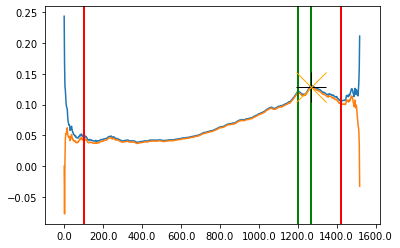

100%|████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:00<00:00, 1252.41it/s]


Plot 42 - Embedding Perm 7 Error: 898.0000 sec.
LR accuracy on training: 0.989448051948052
LR accuracy on downsampled training: 0.803030303030303


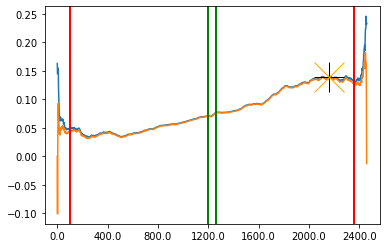

100%|████████████████████████████████████████████████████████████████████████████| 1227/1227 [00:00<00:00, 1383.60it/s]

Plot 43 - Embedding Perm 7 Error: 124.0000 sec.
LR accuracy on training: 0.989413680781759
LR accuracy on downsampled training: 0.7833333333333333


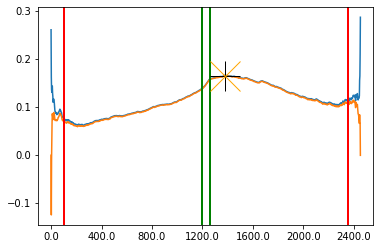

100%|████████████████████████████████████████████████████████████████████████████| 1236/1236 [00:00<00:00, 1360.81it/s]


Plot 44 - Embedding Perm 7 Error: -946.0000 sec.
LR accuracy on training: 0.9870654810024252
LR accuracy on downsampled training: 0.7948717948717948


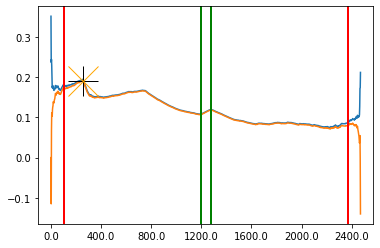

100%|████████████████████████████████████████████████████████████████████████████| 1243/1243 [00:00<00:00, 1332.80it/s]


Plot 45 - Embedding Perm 7 Error: 800.0000 sec.
LR accuracy on training: 0.9790996784565916
LR accuracy on downsampled training: 0.7111111111111111


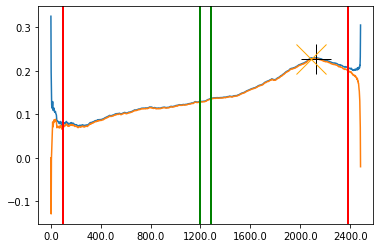

100%|████████████████████████████████████████████████████████████████████████████| 1225/1225 [00:00<00:00, 1237.83it/s]


Plot 46 - Embedding Perm 7 Error: 182.0000 sec.
LR accuracy on training: 0.9836867862969005
LR accuracy on downsampled training: 0.6428571428571429


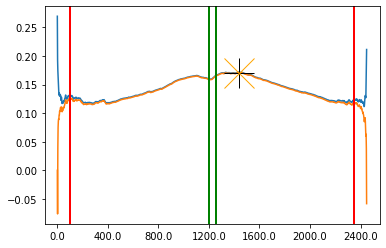

Total accuracy: 0.1702127659574468
LR accuracy on validation: 0.9822419533851277
LR accuracy on downsampled validation: [0.6190476190476191, 0.6190476190476191, 0.6190476190476191, 0.6190476190476191, 0.5952380952380952]


In [14]:
main(emb=7)

5
5


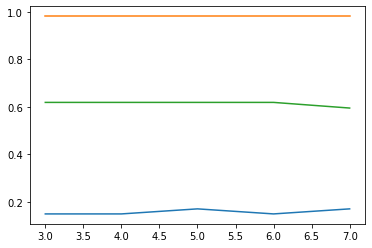

In [15]:
embs = [3,4,5,6,7]
print(len(mmdaccs))
print(len(lraccs))
plt.plot(embs, mmdaccs)
plt.plot(embs, lraccs)
plt.plot(embs, lraccs_down)

In [23]:
table = PrettyTable()
table.field_names = ["Type"] + embs
table.add_row(["MMD Accuracy"] + ["%.6f"%num for num in mmdaccs])
table.add_row(["LR Accuracy"] + ["%.6f"%num for num in lraccs])
table.add_row(["LR Accuracy (Down)"] + ["%.6f"%num for num in lraccs_down])
print(table)

+--------------------+----------+----------+----------+----------+----------+
|        Type        |    3     |    4     |    5     |    6     |    7     |
+--------------------+----------+----------+----------+----------+----------+
|    MMD Accuracy    | 0.148936 | 0.148936 | 0.170213 | 0.148936 | 0.170213 |
|    LR Accuracy     | 0.982242 | 0.982242 | 0.982242 | 0.982242 | 0.982242 |
| LR Accuracy (Down) | 0.619048 | 0.619048 | 0.619048 | 0.619048 | 0.595238 |
+--------------------+----------+----------+----------+----------+----------+


Plot magnitude of coef from LR and us l1 norm penalty (small and large magnitudes)